In [2]:
!pip install rasterio
!pip install whitebox
!pip install tqdm
!pip install tqdm_joblib
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 1.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio.features
import rasterio.warp
import whitebox
from rasterio.enums import Resampling
from rasterio.io import MemoryFile
from rasterio.warp import reproject, calculate_default_transform
import matplotlib.pyplot as plt
import ee
import geemap
from shapely.geometry import Point
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import uniform, randint, loguniform
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor

/usr/local/lib/python3.11/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
#Looking at the metadata and crs of the data that we have

# with rasterio.open(r"C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Data_Raw\2022_farmcrew_n58\USDA_Central Farm_2-71_2022_Soybeans_1\CentralFarm_2-71_2022_Soyb_sph_field2rst_kriged.tif") as src:
with rasterio.open(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/CentralFarm_2-71_2022_Soyb_sph_field2rst_kriged.tif") as src:
    print("\n📊 Raster Metadata:")
    print(" - CRS:", src.crs)
    print(" - Shape:", (src.height, src.width))   # rows, cols
    print(" - Bounds:", src.bounds)
    print(" - Resolution:", src.res)
    print(" - Band count:", src.count)
    print(" - Data type:", src.dtypes)
    print(" - Transform:", src.transform)


📊 Raster Metadata:
 - CRS: EPSG:32618
 - Shape: (132, 76)
 - Bounds: BoundingBox(left=337665.1012349218, bottom=4320176.719129506, right=338047.70454867795, top=4320840.084564871)
 - Resolution: (5.034254128370728, 5.025495722466572)
 - Band count: 1
 - Data type: ('float32',)
 - Transform: | 5.03, 0.00, 337665.10|
| 0.00,-5.03, 4320840.08|
| 0.00, 0.00, 1.00|


In [5]:
#Let;s load all the fields' data:



# 👉 PATH TO ONE CROP FILE

# fn = r"C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data\Raw Yield data\soybeans.parquet"
fn = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/soybeans.parquet"
#Count the number of rows in the file
df = pd.read_parquet(fn)

print(f"Number of rows in the file: {len(df)}")

print(df.info())  # get a summary of the data

#count the number and name of unique fields
print(f"Number of unique fields: {df['field'].nunique()}")
print(f"Unique fields: {df['field'].unique()}")

total_rows = len(df)
missing_per_col = df.isna().sum().to_frame('NaN_count')
missing_per_col['percent'] = 100 * missing_per_col['NaN_count'] / total_rows
print(missing_per_col)

df_yield = df

Number of rows in the file: 611315
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611315 entries, 0 to 611314
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x       611315 non-null  float64
 1   y       611315 non-null  float64
 2   yield   611315 non-null  float64
 3   field   611315 non-null  object 
 4   year    611315 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 23.3+ MB
None
Number of unique fields: 108
Unique fields: ['Central Farm_1-14A' 'Central Farm_1-14B' 'Central Farm_1-14C'
 'Central Farm_1-20A' 'Central Farm_1-20B' 'Central Farm_1-20C'
 'Central Farm_2-32A' 'Central Farm_2-51' 'Central Farm_2-71'
 'Central Farm_2-72' 'Central Farm_4-16' 'Central Farm_4-23A'
 'Central Farm_4-25' 'East Farm_5-23' 'East Farm_5-45A' 'East Farm_5-45D'
 'Linkage Farm_EB-3' 'APU_1-98' 'Central Farm_1-13' 'Central Farm_1-21'
 'Central Farm_1-33' 'Central Farm_1-34' 'Central Farm_1-37'
 'Central Farm_1-7

In [18]:

print(df_yield.head(50))

                x             y      yield               field  year
0   336575.242354  4.322261e+06  68.618011  Central Farm_1-14A  2014
1   336580.326059  4.322261e+06  63.755882  Central Farm_1-14A  2014
2   336570.158649  4.322256e+06  70.386627  Central Farm_1-14A  2014
3   336575.242354  4.322256e+06  66.414635  Central Farm_1-14A  2014
4   336580.326059  4.322256e+06  59.465141  Central Farm_1-14A  2014
5   336585.409764  4.322256e+06  55.322681  Central Farm_1-14A  2014
6   336559.991239  4.322251e+06  78.832695  Central Farm_1-14A  2014
7   336565.074944  4.322251e+06  73.406586  Central Farm_1-14A  2014
8   336570.158649  4.322251e+06  67.883461  Central Farm_1-14A  2014
9   336575.242354  4.322251e+06  61.420727  Central Farm_1-14A  2014
10  336580.326059  4.322251e+06  53.015484  Central Farm_1-14A  2014
11  336585.409764  4.322251e+06  51.103939  Central Farm_1-14A  2014
12  336590.493469  4.322251e+06  48.832870  Central Farm_1-14A  2014
13  336554.907534  4.322246e+06  8

In [6]:


# dst_dem_resampled = r"C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data\DEM_5m_UTM18.tif"
dst_dem_resampled = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/DEM_5m_UTM18.tif"

# Step 1: Open the resampled DEM
with rasterio.open(dst_dem_resampled) as dem_src:

    # Step 2: Create list of (x, y) coordinate pairs
    coords = list(zip(df_yield['x'], df_yield['y']))

    # Step 3: Sample elevation values at those coordinates
    elevation_vals = [val[0] for val in dem_src.sample(coords)]

# Step 4: Add to DataFrame
df_yield['elevation'] = elevation_vals

# Step 5: Preview
(df_yield.head())

,x,y,yield,field,year,elevation
0,336575.242354,4.322261e+06,68.618011,Central Farm_1-14A,2014,45.632698
1,336580.326059,4.322261e+06,63.755882,Central Farm_1-14A,2014,45.842655
2,336570.158649,4.322256e+06,70.386627,Central Farm_1-14A,2014,45.935165
3,336575.242354,4.322256e+06,66.414635,Central Farm_1-14A,2014,46.113899
4,336580.326059,4.322256e+06,59.465141,Central Farm_1-14A,2014,46.339870


In [ ]:

# 1) Make a GeoDataFrame assuming your x,y are in EPSG:32618
gdf = gpd.GeoDataFrame(
    df_yield,
    geometry=gpd.points_from_xy(df_yield['x'], df_yield['y']),
    crs='EPSG:32618'  # <- IMPORTANT: change if wrong
)

# 2) Check vs DEM bounds
dem_path = r"C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data\DEM_5m_UTM18.tif"
with rasterio.open(dem_path) as src:
    b = src.bounds
    print("DEM CRS:", src.crs)
    print("DEM bounds:", b)

inside = (
    (gdf.geometry.x >= b.left) & (gdf.geometry.x <= b.right) &
    (gdf.geometry.y >= b.bottom) & (gdf.geometry.y <= b.top)
)
print("Total points:", len(gdf))
print("Points inside DEM bounds:", inside.sum(), f"({inside.mean()*100:.2f}%)")


DEM CRS: EPSG:32618
DEM bounds: BoundingBox(left=330908.9440308713, bottom=4318195.756654576, right=343368.72299858887, top=4323573.037077616)
Total points: 611315
Points inside DEM bounds: 611281 (99.99%)


In [22]:
#print null values in the elevation column
print(df_yield['elevation'].isnull().sum())


print(df_yield['elevation'].describe())

0
count    611315.000000
mean         38.389294
std           6.993091
min           0.000000
25%          32.996063
50%          38.237869
75%          42.904743
max          80.984177
Name: elevation, dtype: float64


In [ ]:

wbt = whitebox.WhiteboxTools()

# Set the working directory (optional, but helpful)
wbt.set_working_dir("C:\\Users\\acer\\OneDrive - Texas State University\\ChoLab\\USDA Crop yield Stability Study\\BARC_Yield_Analysis\\Prediction\\Data")

wbt.slope(
    dem="C:\\Users\\acer\\OneDrive - Texas State University\\ChoLab\\USDA Crop yield Stability Study\\BARC_Yield_Analysis\\Prediction\\Data\\DEM_5m_UTM18.tif",      # Input DEM
    output="C:\\Users\\acer\\OneDrive - Texas State University\\ChoLab\\USDA Crop yield Stability Study\\BARC_Yield_Analysis\\Prediction\\Data\\slope.tif",           # Output slope raster
    zfactor=None                  # Optional: Use if elevation is in meters and coordinates are in degrees
)

wbt.aspect(
    dem="C:\\Users\\acer\\OneDrive - Texas State University\\ChoLab\\USDA Crop yield Stability Study\\BARC_Yield_Analysis\\Prediction\\Data\\DEM_5m_UTM18.tif",      # Input DEM
    output="C:\\Users\\acer\\OneDrive - Texas State University\\ChoLab\\USDA Crop yield Stability Study\\BARC_Yield_Analysis\\Prediction\\Data\\aspect.tif",          # Output aspect raster
    zfactor=None                  # Optional: Use if elevation is in meters and coordinates are in degrees
)


.\whitebox_tools.exe --run="Slope" --wd="C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data" --dem='C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data\DEM_5m_UTM18.tif' --output='C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data\slope.tif' --units=degrees -v --compress_rasters=False

****************************
* Welcome to Slope         *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%

0

In [23]:
# with rasterio.open(r"C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data\slope.tif") as slope_src:
with rasterio.open(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/slope.tif") as slope_src:
    coords = list(zip(df_yield['x'], df_yield['y']))
    slope_vals = [val[0] for val in slope_src.sample(coords)]

# with rasterio.open(r"C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data\aspect.tif") as aspect_src:
with rasterio.open(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/aspect.tif") as aspect_src:
    coords = list(zip(df_yield['x'], df_yield['y']))
    aspect_vals = [val[0] for val in aspect_src.sample(coords)]

df_yield['slope'] = slope_vals
df_yield['aspect'] = aspect_vals
df_yield.head()

,x,y,yield,field,year,elevation,slope,aspect
0,336575.242354,4.322261e+06,68.618011,Central Farm_1-14A,2014,45.632698,5.619898,339.101105
1,336580.326059,4.322261e+06,63.755882,Central Farm_1-14A,2014,45.842655,5.968995,337.149445
2,336570.158649,4.322256e+06,70.386627,Central Farm_1-14A,2014,45.935165,5.391035,335.693298
3,336575.242354,4.322256e+06,66.414635,Central Farm_1-14A,2014,46.113899,5.871187,336.441437
4,336580.326059,4.322256e+06,59.465141,Central Farm_1-14A,2014,46.339870,6.242173,336.157227


In [22]:
print("Df Yield describe: ",df_yield.describe())
missing_slope = (df_yield['slope'] <= 0).sum()
missing_aspect = (df_yield['aspect'] <= 0).sum()

print("Rows with NoData slope (0):", missing_slope)
print("Rows with NoData aspect (0):", missing_aspect)

Df Yield describe:                     x             y          yield           year  \
count  611315.000000  6.113150e+05  611315.000000  611315.000000   
mean   337339.638666  4.321327e+06      46.694985    2019.207328   
std      2571.816114  8.672437e+02      16.998010       2.978032   
min    330893.532259  4.318616e+06       4.139045    2014.000000   
25%    336099.599602  4.320616e+06      34.509420    2017.000000   
50%    336840.073515  4.321341e+06      46.845428    2019.000000   
75%    339214.129061  4.321947e+06      59.010979    2022.000000   
max    342733.656286  4.323242e+06     116.790192    2024.000000   

           elevation          slope         aspect  
count  611315.000000  611315.000000  611315.000000  
mean       38.389294       0.518345     187.043304  
std         6.993091     244.386002     266.547119  
min         0.000000  -32768.000000  -32768.000000  
25%        32.996063       1.187542     104.177971  
50%        38.237869       2.018188     195.36261

In [24]:
df_yield = df_yield[(df_yield['slope'] >= 0) & (df_yield['aspect'] >= 0)]

# 3. Confirm
print("Remaining rows:", len(df_yield))

Remaining rows: 611229


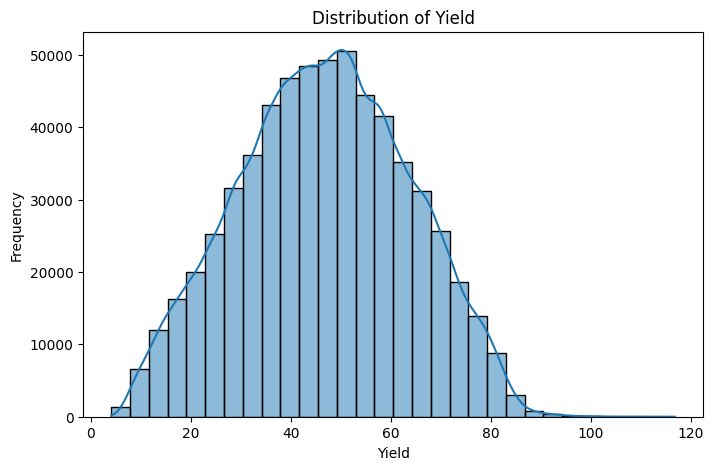

In [ ]:
# Distribution plot of yield
plt.figure(figsize=(8, 5))
sns.histplot(df_yield['yield'], bins=30, kde=True)
plt.title("Distribution of Yield")
plt.xlabel("Yield")
plt.ylabel("Frequency")
plt.show()


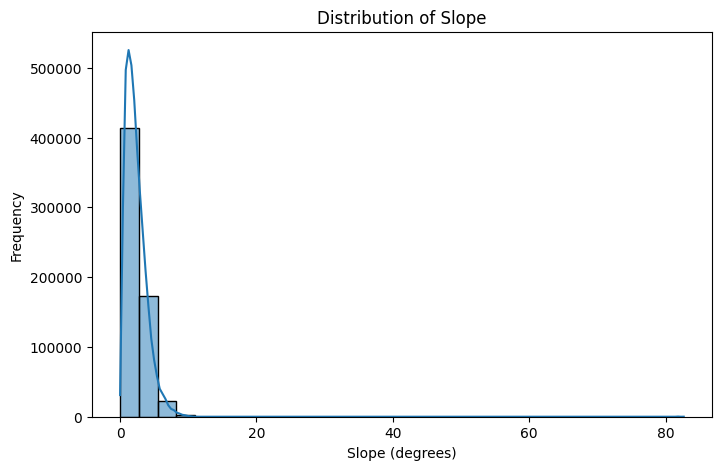

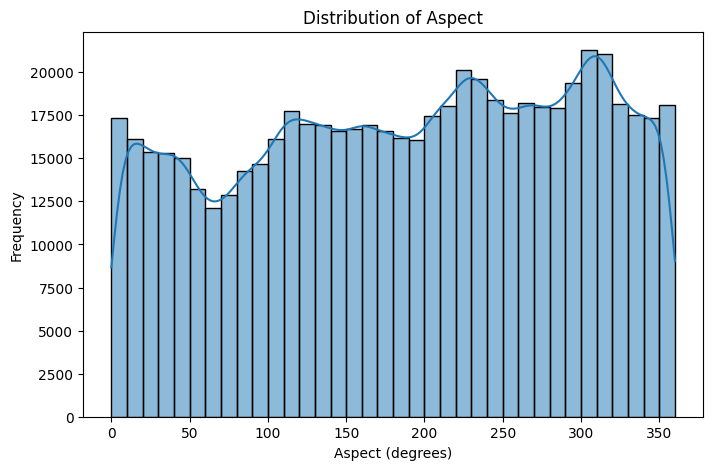

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df_yield['slope'], bins=30, kde=True)
plt.title("Distribution of Slope")
plt.xlabel("Slope (degrees)")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df_yield['aspect'], bins=36, kde=True)  # 36 bins for 10° intervals
plt.title("Distribution of Aspect")
plt.xlabel("Aspect (degrees)")
plt.ylabel("Frequency")
plt.show()


In [ ]:
#Clearning data



# 3.  Optionally: treat physically impossible values as NA as well
df_yield.loc[~df_yield["slope"].between(0, 90),  "slope"]  = pd.NA
df_yield.loc[~df_yield["aspect"].between(0, 360), "aspect"] = pd.NA

df_yield = df_yield.dropna(subset=["slope", "aspect"]).reset_index(drop=True)

In [10]:
print(df_map['2020-2023'].describe())

                   x             y          yield           year  \
count  281684.000000  2.816840e+05  281684.000000  281684.000000   
mean   337369.339081  4.321337e+06      48.633879    2021.855526   
std      2483.600265  9.057092e+02      17.814286       1.445908   
min    330929.234646  4.318616e+06       4.139045    2020.000000   
25%    336155.011274  4.320579e+06      36.009022    2020.000000   
50%    337084.109707  4.321326e+06      50.715670    2022.000000   
75%    339607.031825  4.322064e+06      62.135865    2023.000000   
max    342733.656286  4.323242e+06      89.823845    2024.000000   

           elevation          slope         aspect  aspect_southness  \
count  281684.000000  281684.000000  281684.000000     281684.000000   
mean       38.245575       2.391808     191.056412          0.496911   
std         6.655244       1.727813     104.029625          0.291042   
min         0.000000       0.003039       0.011794          0.000020   
25%        33.266102       

In [25]:
# Create aspect southness
df_yield['aspect_southness'] = 1 - np.abs((df_yield['aspect'] - 180) / 180)

# Add polynomial features
df_yield['slope_squared'] = df_yield['slope'] ** 2
df_yield['elevation_squared'] = df_yield['elevation'] ** 2

# Add interaction features
df_yield['elev_slope'] = df_yield['elevation'] * df_yield['slope']
df_yield['elev_aspect'] = df_yield['elevation'] * df_yield['aspect_southness']
df_yield['slope_aspect'] = df_yield['slope'] * df_yield['aspect_southness']
features = [
    'elevation', 'slope', 'aspect_southness',
    'slope_squared', 'elevation_squared',
    'elev_slope', 'elev_aspect', 'slope_aspect'
]

print(df_yield.info())

<class 'pandas.core.frame.DataFrame'>
Index: 611229 entries, 0 to 611314
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   x                  611229 non-null  float64
 1   y                  611229 non-null  float64
 2   yield              611229 non-null  float64
 3   field              611229 non-null  object 
 4   year               611229 non-null  int64  
 5   elevation          611229 non-null  float32
 6   slope              611229 non-null  float32
 7   aspect             611229 non-null  float32
 8   aspect_southness   611229 non-null  float32
 9   slope_squared      611229 non-null  float32
 10  elevation_squared  611229 non-null  float32
 11  elev_slope         611229 non-null  float32
 12  elev_aspect        611229 non-null  float32
 13  slope_aspect       611229 non-null  float32
dtypes: float32(9), float64(3), int64(1), object(1)
memory usage: 49.0+ MB
None


/tmp/ipython-input-32145337.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yield['aspect_southness'] = 1 - np.abs((df_yield['aspect'] - 180) / 180)
/tmp/ipython-input-32145337.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yield['slope_squared'] = df_yield['slope'] ** 2
/tmp/ipython-input-32145337.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [26]:
#For year 2022:
df_yield_2022 = df_yield[df_yield['year'] == 2022].copy()
df_yield_2021 = df_yield[df_yield['year'] == 2021].copy()

df_map={
    2021: df_yield_2021,
    2022: df_yield_2022,
    2020: df_yield[df_yield['year'] == 2020],
}

print("Data for 2022:")
print(df_map[2021].describe())

# df_yield_2021.describe()

Data for 2022:
                   x             y         yield     year     elevation  \
count   54042.000000  5.404200e+04  54042.000000  54042.0  54042.000000   
mean   337504.593791  4.321479e+06     56.795408   2021.0     38.828045   
std      2899.451391  9.138916e+02     14.250213      0.0      6.537268   
min    331105.728267  4.319823e+06      5.417891   2021.0     24.478294   
25%    336137.012780  4.320659e+06     51.194778   2021.0     33.751885   
50%    336504.804057  4.321460e+06     58.817595   2021.0     38.436811   
75%    340011.457845  4.322195e+06     66.462645   2021.0     43.373920   
max    342733.656286  4.323242e+06     88.294991   2021.0     67.875549   

              slope        aspect  aspect_southness  slope_squared  \
count  54042.000000  54042.000000      54042.000000   54042.000000   
mean       2.285732    196.308929          0.481346       7.700341   
std        1.573471    104.512436          0.276273      11.198924   
min        0.021400      0.01

In [4]:
# df_map[2023] = df_yield[df_yield['year'] == 2023].copy()
# df_map.keys()


#merging multiple df into one
# df_map["2020-2023"] = pd.concat(df_map.values(), keys=df_map.keys())
# df_map["2020-2023"]['year'].value_counts()

#counting rows containing na values
# df_map["2020-2023"].isna().sum()


# #reloading data :
df_map = {}
# df_yield_2020_2023 = pd.read_parquet(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/Saved_df_map/df_yield_2020-2023.parquet")
df_map["2020-2023"] = pd.read_parquet(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/Saved_df_map/df_yield_2020-2023.parquet")
print(df_map['2020-2023'].describe())

df_map[2024] = pd.read_parquet(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/Saved_df_map/df_yield_2024.parquet")
df_map[2023] = pd.read_parquet(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/Saved_df_map/df_yield_2023.parquet")
df_map[2022] = pd.read_parquet(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/Saved_df_map/df_yield_2022.parquet")
df_map[2021] = pd.read_parquet(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/Saved_df_map/df_yield_2021.parquet")
df_map[2020] = pd.read_parquet(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/Saved_df_map/df_yield_2020.parquet")
# df_map[2024]['year'].value_counts()

                   x             y          yield           year  \
count  281684.000000  2.816840e+05  281684.000000  281684.000000   
mean   337369.339081  4.321337e+06      48.633879    2021.855526   
std      2483.600265  9.057092e+02      17.814286       1.445908   
min    330929.234646  4.318616e+06       4.139045    2020.000000   
25%    336155.011274  4.320579e+06      36.009022    2020.000000   
50%    337084.109707  4.321326e+06      50.715670    2022.000000   
75%    339607.031825  4.322064e+06      62.135865    2023.000000   
max    342733.656286  4.323242e+06      89.823845    2024.000000   

           elevation          slope         aspect  aspect_southness  \
count  281684.000000  281684.000000  281684.000000     281684.000000   
mean       38.245575       2.391808     191.056412          0.496911   
std         6.655244       1.727813     104.029625          0.291042   
min         0.000000       0.003039       0.011794          0.000020   
25%        33.266102       

In [42]:
df_map[2023].info()

<class 'pandas.core.frame.DataFrame'>
Index: 44141 entries, 0 to 44140
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   x                  44141 non-null  float64
 1   y                  44141 non-null  float64
 2   yield              44141 non-null  float64
 3   field              44141 non-null  object 
 4   year               44141 non-null  int64  
 5   elevation          44141 non-null  float32
 6   slope              44141 non-null  float32
 7   aspect             44141 non-null  float32
 8   aspect_southness   44141 non-null  float32
 9   slope_squared      44141 non-null  float32
 10  elevation_squared  44141 non-null  float32
 11  elev_slope         44141 non-null  float32
 12  elev_aspect        44141 non-null  float32
 13  slope_aspect       44141 non-null  float32
 14  ndvi_mean          44141 non-null  float64
 15  lst_median         44141 non-null  float64
 16  pr_season_mm_x     44141 no

In [44]:
# df_map[2023] = pd.read_parquet(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/Saved_df_map/df_yield_2023.parquet")
# df_map.keys()
# df_map["2020-2023"]['year'].value_counts()

# df_map[2023] = df_map['2020-2023'][df_map['2020-2023']['year'] == 2023]
# df_map["2020-2022"] = df_map["2020-2023"][
#     df_map["2020-2023"]["year"].isin([2020, 2021, 2022])
# ]

df_map['2020-2022'] = pd.concat([df_map[2020], df_map[2021], df_map[2022]]).reset_index(drop=True)
# df_map[2023]['year'].value_counts()

df_map["2020-2022"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183466 entries, 0 to 183465
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   x                  183466 non-null  float64
 1   y                  183466 non-null  float64
 2   yield              183466 non-null  float64
 3   field              183466 non-null  object 
 4   year               183466 non-null  int64  
 5   elevation          183466 non-null  float32
 6   slope              183466 non-null  float32
 7   aspect             183466 non-null  float32
 8   aspect_southness   183466 non-null  float32
 9   slope_squared      183466 non-null  float32
 10  elevation_squared  183466 non-null  float32
 11  elev_slope         183466 non-null  float32
 12  elev_aspect        183466 non-null  float32
 13  slope_aspect       183466 non-null  float32
 14  ndvi_mean          183466 non-null  float64
 15  lst_median         183466 non-null  float64
 16  pr

In [27]:
# Create aspect southness
df_yield_2021['aspect_southness'] = 1 - np.abs((df_yield_2021['aspect'] - 180) / 180)

# Add polynomial features
df_yield_2021['slope_squared'] = df_yield_2021['slope'] ** 2
df_yield_2021['elevation_squared'] = df_yield_2021['elevation'] ** 2

# Add interaction features
df_yield_2021['elev_slope'] = df_yield_2021['elevation'] * df_yield_2021['slope']
df_yield_2021['elev_aspect'] = df_yield_2021['elevation'] * df_yield_2021['aspect_southness']
df_yield_2021['slope_aspect'] = df_yield_2021['slope'] * df_yield_2021['aspect_southness']
features = [
    'elevation', 'slope', 'aspect_southness',
    'slope_squared', 'elevation_squared',
    'elev_slope', 'elev_aspect', 'slope_aspect'
]

print(df_yield_2021.info())

<class 'pandas.core.frame.DataFrame'>
Index: 54042 entries, 391333 to 445374
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   x                  54042 non-null  float64
 1   y                  54042 non-null  float64
 2   yield              54042 non-null  float64
 3   field              54042 non-null  object 
 4   year               54042 non-null  int64  
 5   elevation          54042 non-null  float32
 6   slope              54042 non-null  float32
 7   aspect             54042 non-null  float32
 8   aspect_southness   54042 non-null  float32
 9   slope_squared      54042 non-null  float32
 10  elevation_squared  54042 non-null  float32
 11  elev_slope         54042 non-null  float32
 12  elev_aspect        54042 non-null  float32
 13  slope_aspect       54042 non-null  float32
dtypes: float32(9), float64(3), int64(1), object(1)
memory usage: 4.3+ MB
None


In [9]:


# Authenticate and initialize
ee.Authenticate()
# Replace 'your-google-cloud-project-id' with your actual Google Cloud Project ID
ee.Initialize(project='cho-lab-prj')

In [81]:
import_year = 2023

# Create a GeoDataFrame from your pandas DataFrame
# The coordinates are assumed to be in a projected system (e.g., UTM Zone 17N)
gdf_yield = gpd.GeoDataFrame(
    df_map[import_year],
    geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
    crs='EPSG:32618'  # Replace with the correct CRS for your data if different
)

# Convert the GeoDataFrame to WGS84 (EPSG:4326), which is the standard CRS for GEE
# We also reset the index to a column so we can reliably merge later.
gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index()



### Let's Try Importing NDVI Data for a year

In [101]:



# --------------------------------------------------------------------------------
# Step 2: Define image processing functions for GEE
# --------------------------------------------------------------------------------

def add_ndvi(image):
    """
    A GEE server-side function to add a cloud mask and NDVI band to a Sentinel-2 image.
    This function is mapped over the entire image collection.
    """
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    image = image.updateMask(mask).divide(10000)
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)


# --------------------------------------------------------------------------------
# Step 3: Process the data in batches to avoid server-side limits
# --------------------------------------------------------------------------------

batch_size = 5000  # You can adjust this value based on your internet speed and data density
all_results = []
num_rows = len(gdf_yield_wgs84)

print(f"Starting to process {num_rows} points in batches of {batch_size}...")

for start_index in range(0, num_rows, batch_size):
    try:
        end_index = min(start_index + batch_size, num_rows)
        batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

        # Convert the current batch of points to a GEE FeatureCollection
        ee_feature_collection = ee.FeatureCollection(batch_gdf.__geo_interface__)

        # Define the Sentinel-2 image collection and filter it by date and the batch's bounds
        s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterDate(f'{import_year}-04-15', f'{import_year}-10-07') \
            .filterBounds(ee_feature_collection.geometry()) \
            .map(add_ndvi)

        # Compute the annual mean NDVI for each pixel over the entire time period.
        # This creates a single image where each pixel's value is the mean NDVI over the year.
        ndvi_mean = s2_collection.select('NDVI').mean()

        # Get the value for EACH point from the annual mean image.
        results = ndvi_mean.reduceRegions(
            collection=ee_feature_collection,
            reducer=ee.Reducer.mean(),
            scale=10
        )

        # Download the results for this batch and store them
        result_list = results.getInfo()['features']
        ndvi_data_batch = []
        for feature in result_list:
            ndvi_value = feature['properties'].get('mean')
            original_index = feature['properties'].get('index')
            ndvi_data_batch.append({'index': original_index, 'ndvi_mean': ndvi_value})

        df_ndvi_batch = pd.DataFrame(ndvi_data_batch)
        all_results.append(df_ndvi_batch)

        print(f"Batch {start_index} to {end_index} processed successfully.")

    except Exception as e:
        print(f"Error processing batch {start_index} to {end_index}: {e}")
        # Append an empty DataFrame to maintain consistency if a batch fails
        all_results.append(pd.DataFrame(columns=['index', 'ndvi_mean']))


# --------------------------------------------------------------------------------
# Step 4: Combine all batch results and merge with the original DataFrame
# --------------------------------------------------------------------------------

if all_results:
    # Concatenate all batch results into one master DataFrame
    df_all_ndvi = pd.concat(all_results, ignore_index=True)
else:
    df_all_ndvi = pd.DataFrame(columns=['index', 'ndvi_mean'])

# Merge the new NDVI data with your original DataFrame based on the index
df_yield_with_index = df_map[import_year].reset_index()
df_final = df_yield_with_index.merge(df_all_ndvi, on='index', how='left')
df_final = df_final.set_index('index')
df_map[import_year] = df_final.copy()
# Final check of the DataFrame
print("\nProcessing complete. The final DataFrame with unique NDVI scores for each pixel looks like this:")
print(df_final.head())
print(f"\nFinal DataFrame shape: {df_final.shape}")

Starting to process 47743 points in batches of 5000...
Batch 0 to 5000 processed successfully.
Batch 5000 to 10000 processed successfully.
Batch 10000 to 15000 processed successfully.
Batch 15000 to 20000 processed successfully.
Batch 20000 to 25000 processed successfully.
Batch 25000 to 30000 processed successfully.
Batch 30000 to 35000 processed successfully.
Batch 35000 to 40000 processed successfully.
Batch 40000 to 45000 processed successfully.
Batch 45000 to 47743 processed successfully.

Processing complete. The final DataFrame with unique NDVI scores for each pixel looks like this:
                    x             y      yield  field  year  elevation  \
index                                                                    
508040  336225.541109  4.320258e+06  16.962738  APU_4  2023  33.036472   
508041  336230.656534  4.320258e+06  22.184467  APU_4  2023  33.387596   
508042  336235.771959  4.320258e+06  30.533930  APU_4  2023  33.770084   
508043  336240.887384  4.320258e+

### Let's try importing LST Values:

In [102]:

def add_lst(image):
    """
    A GEE server-side function to add a cloud mask and LST band to a Landsat image.
    This function is mapped over the entire image collection.
    """
    qa = image.select('QA_PIXEL')
    cloud_bit_mask = 1 << 3
    shadow_bit_mask = 1 << 4
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(shadow_bit_mask).eq(0))
    image = image.updateMask(mask)
    lst_k = image.select('ST_B10').multiply(0.00341802).add(149).rename('LST_K')
    return image.addBands(lst_k)




batch_size = 5000  # You can adjust this value based on your internet speed and data density
all_results = []
num_rows = len(gdf_yield_wgs84)

print(f"Starting to process {num_rows} points in batches of {batch_size}...")

for start_index in range(0, num_rows, batch_size):
    print(f"Processing batch {start_index} to {start_index + batch_size}")
    try:
        end_index = min(start_index + batch_size, num_rows)
        batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index].reset_index()

        # Convert the current batch of points to a GEE FeatureCollection
        ee_feature_collection = ee.FeatureCollection([
            ee.Feature(
                ee.Geometry.Point(row.geometry.x, row.geometry.y),
                {'index': int(row['index'])}
            )
            for _, row in batch_gdf.iterrows()
        ])

        collection_id = (
                            'LANDSAT/LC08/C02/T1_L2' if import_year < 2022
                            else 'LANDSAT/LC09/C02/T1_L2'
                        )

        # Define the Sentinel-2 image collection and filter it by date and the batch's bounds
        landsat_collection = ee.ImageCollection(collection_id) \
            .filterDate(f'{import_year}-04-15', f'{import_year}-10-07') \
            .filterBounds(ee_feature_collection.geometry()) \
            .map(add_lst)

        # Compute the annual mean LST for each pixel over the entire time period.
        # This creates a single image where each pixel's value is the mean LST over the year.
        lst_median = landsat_collection.select('LST_K').median().toFloat()

        # Get the value for EACH point from the annual mean image.
        results = lst_median.reduceRegions(
            collection=ee_feature_collection,
            reducer=ee.Reducer.first(),
            scale=30
        )

        print("Results Size: ", results.size().getInfo())
        # Download the results for this batch and store them
        result_list = results.getInfo()['features']
        lst_data_batch = []
        for feature in result_list:
            # print("Feature: ", feature)
            # print("Feature properties: ", feature['properties'])
            lst_value = feature['properties'].get('first')
            original_index = feature['properties'].get('index')
            lst_data_batch.append({'index': original_index, 'lst_median': lst_value})

        df_lst_batch = pd.DataFrame(lst_data_batch)
        all_results.append(df_lst_batch)

        print(f"Batch {start_index} to {end_index} processed successfully.")

    except Exception as e:
        print(f"Error processing batch {start_index} to {end_index}: {e}")
        # Append an empty DataFrame to maintain consistency if a batch fails
        all_results.append(pd.DataFrame(columns=['index', 'lst_median']))


df_all_lst = pd.concat(all_results, ignore_index=True) if all_results else pd.DataFrame(columns=['index','lst_median'])
df_all_lst = (df_all_lst.dropna(subset=['index'])
                         .astype({'index':'int64'})
                         .drop_duplicates('index', keep='last'))

left = df_map[import_year].reset_index().copy()
left['index'] = left['index'].astype('int64')
s = df_all_lst.set_index('index')['lst_median']
left['lst_median'] = left['index'].map(s)
df_final = left.set_index('index')


# -------------------------------------

Starting to process 47743 points in batches of 5000...
Processing batch 0 to 5000
Results Size:  5000
Batch 0 to 5000 processed successfully.
Processing batch 5000 to 10000
Results Size:  5000
Batch 5000 to 10000 processed successfully.
Processing batch 10000 to 15000
Results Size:  5000
Batch 10000 to 15000 processed successfully.
Processing batch 15000 to 20000
Results Size:  5000
Batch 15000 to 20000 processed successfully.
Processing batch 20000 to 25000
Results Size:  5000
Batch 20000 to 25000 processed successfully.
Processing batch 25000 to 30000
Results Size:  5000
Batch 25000 to 30000 processed successfully.
Processing batch 30000 to 35000
Results Size:  5000
Batch 30000 to 35000 processed successfully.
Processing batch 35000 to 40000
Results Size:  5000
Batch 35000 to 40000 processed successfully.
Processing batch 40000 to 45000
Results Size:  5000
Batch 40000 to 45000 processed successfully.
Processing batch 45000 to 50000
Results Size:  2743
Batch 45000 to 47743 processed s

## Precipitation Data Import


In [82]:
# --- One-time prep: make a stable row id ('index') ONCE ---
gdf_yield_wgs84 = gdf_yield_wgs84.reset_index(drop=True).copy()
gdf_yield_wgs84['index'] = gdf_yield_wgs84.index.astype(int)

batch_size = 5000
all_results = []
num_rows = len(gdf_yield_wgs84)

# --- Crop window (same as your example; change as needed) ---
start_mmdd = '04-15'
end_mmdd   = '10-07'
start_date = f'{import_year}-{start_mmdd}'
end_date   = f'{import_year}-{end_mmdd}'

# --- Precompute seasonal precip & aridity ONCE for the year (faster) ---
gridmet = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET').filterDate(start_date, end_date)

precip_sum = (gridmet
              .select('pr')               # mm/day
              .sum()                      # mm over window
              .rename('pr_season_mm')
              .toFloat())

eto_sum = (gridmet
           .select('eto')                 # mm/day
           .sum()
           .toFloat())

aridity = precip_sum.divide(eto_sum).rename('aridity')  # dimensionless

# Stack both bands so we sample once
stack = precip_sum.addBands(aridity)

print(f"Starting to process {num_rows} points in batches of {batch_size}...")

for start_index in range(0, num_rows, batch_size):
    end_index = min(start_index + batch_size, num_rows)
    print(f"Processing batch {start_index} to {end_index}")
    try:
        batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

        # Points → ee.FeatureCollection with 'index'
        ee_feature_collection = ee.FeatureCollection([
            ee.Feature(
                ee.Geometry.Point(row.geometry.x, row.geometry.y),
                {'index': int(row['index'])}
            )
            for _, row in batch_gdf.iterrows()
        ])

        # Sample BOTH pr_season_mm and aridity at native GRIDMET scale
        samples = stack.sampleRegions(
            collection=ee_feature_collection,
            scale=4000,          # GRIDMET native resolution
            geometries=False
        )

        # Download this batch
        result_list = samples.getInfo()['features']
        rows = []
        for ft in result_list:
            props = ft['properties']
            rows.append({
                'index': props.get('index'),
                'pr_season_mm': props.get('pr_season_mm'),
                'aridity': props.get('aridity')
            })

        all_results.append(pd.DataFrame(rows))
        print(f"Batch {start_index} to {end_index} processed successfully.")

    except Exception as e:
        print(f"Error processing batch {start_index} to {end_index}: {e}")
        all_results.append(pd.DataFrame(columns=['index', 'pr_season_mm', 'aridity']))

# ---- Combine batches & merge back to your year table -------------------
df_all_climate = (pd.concat(all_results, ignore_index=True)
                  if all_results else pd.DataFrame(columns=['index','pr_season_mm','aridity']))

df_all_climate = (df_all_climate.dropna(subset=['index'])
                                   .astype({'index':'int64'})
                                   .drop_duplicates('index', keep='last'))

# If this table comes from the SAME base rows as gdf_yield_wgs84, carry the same 'index' over:
left = df_map[import_year].copy()
left = left.reset_index(drop=True)
left['index'] = left.index.astype('int64')

df_final = (left
            .merge(df_all_climate, on='index', how='left')
            .set_index('index'))

# Optional: for modeling, you may want to z-score these per year:
# for col in ['pr_season_mm', 'aridity']:
#     df_final[col + '_z'] = df_final.groupby('year')[col].transform(lambda s: (s - s.mean()) / (s.std(ddof=0) + 1e-9))


Starting to process 44141 points in batches of 5000...
Processing batch 0 to 5000
Batch 0 to 5000 processed successfully.
Processing batch 5000 to 10000
Batch 5000 to 10000 processed successfully.
Processing batch 10000 to 15000
Batch 10000 to 15000 processed successfully.
Processing batch 15000 to 20000
Batch 15000 to 20000 processed successfully.
Processing batch 20000 to 25000
Batch 20000 to 25000 processed successfully.
Processing batch 25000 to 30000
Batch 25000 to 30000 processed successfully.
Processing batch 30000 to 35000
Batch 30000 to 35000 processed successfully.
Processing batch 35000 to 40000
Batch 35000 to 40000 processed successfully.
Processing batch 40000 to 44141
Batch 40000 to 44141 processed successfully.


In [84]:
# df_map[2023]=df_map[2023].drop(columns= ['pr_season_mm_x', 	'aridity_x' ,	'pr_season_mm_y', 	'aridity_y' ,	'pr_season_mm' ,	'aridity'], axis = 1)
df_map[import_year] = df_final.copy()
df_map[2023].head(50)

,x,y,yield,field,year,elevation,slope,aspect,aspect_southness,slope_squared,elevation_squared,elev_slope,elev_aspect,slope_aspect,ndvi_mean,lst_median,pr_season_mm,aridity
index,,,,,,,,,,,,,,,,,,
0,336225.541109,4.320258e+06,16.962738,APU_4,2023,33.036472,3.216921,268.699402,0.507226,10.348578,1091.408447,106.275711,16.756941,1.631704,0.289220,29.700220,559.0,0.723531
1,336230.656534,4.320258e+06,22.184467,APU_4,2023,33.387596,3.883270,264.190735,0.532274,15.079782,1114.731567,129.653030,17.771339,2.066962,0.294471,29.043939,559.0,0.723531
2,336235.771959,4.320258e+06,30.533930,APU_4,2023,33.770084,4.529971,257.659088,0.568561,20.520638,1140.418579,152.977509,19.200340,2.575563,0.294471,29.043939,559.0,0.723531
3,336240.887384,4.320258e+06,37.951859,APU_4,2023,34.152328,5.664733,253.114380,0.593809,32.089199,1166.381592,193.463821,20.279961,3.363770,0.302170,29.043939,559.0,0.723531
4,336246.002808,4.320258e+06,42.643795,APU_4,2023,34.666386,6.548505,251.132965,0.604817,42.882915,1201.758301,227.013000,20.966814,3.960646,0.302170,29.043939,559.0,0.723531
5,336251.118233,4.320258e+06,48.102711,APU_4,2023,35.207973,6.864452,251.651535,0.601936,47.120705,1239.601440,241.683456,21.192944,4.131960,0.302170,29.043939,559.0,0.723531
6,336256.233658,4.320258e+06,48.271343,APU_4,2023,35.832119,7.068452,255.425232,0.580971,49.963020,1283.940796,253.277618,20.817419,4.106565,0.307322,28.594476,559.0,0.723531
7,336261.349083,4.320258e+06,48.204075,APU_4,2023,36.418812,6.759203,259.435577,0.558691,45.686825,1326.329834,246.162140,20.346872,3.776308,0.313204,28.594476,559.0,0.723531
8,336266.464508,4.320258e+06,48.219166,APU_4,2023,36.983059,6.401473,264.939056,0.528116,40.978851,1367.746704,236.746033,19.531359,3.380722,0.313204,28.594476,559.0,0.723531


In [62]:
df_map[2020].info()

<class 'pandas.core.frame.DataFrame'>
Index: 70670 entries, 0 to 70669
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   x                  70670 non-null  float64
 1   y                  70670 non-null  float64
 2   yield              70670 non-null  float64
 3   field              70670 non-null  object 
 4   year               70670 non-null  int64  
 5   elevation          70670 non-null  float32
 6   slope              70670 non-null  float32
 7   aspect             70670 non-null  float32
 8   aspect_southness   70670 non-null  float32
 9   slope_squared      70670 non-null  float32
 10  elevation_squared  70670 non-null  float32
 11  elev_slope         70670 non-null  float32
 12  elev_aspect        70670 non-null  float32
 13  slope_aspect       70670 non-null  float32
 14  ndvi_mean          70670 non-null  float64
 15  lst_median         70670 non-null  float64
 16  pr_season_mm       70670 no

In [19]:
print(df_map[import_year]['aridity'].value_counts())

aridity
0.723531    23398
0.730034    18491
0.718240     1187
0.751886     1065
Name: count, dtype: int64


In [29]:
# 1) pixel indices at GRIDMET scale for each point
proj = precip_sum.projection()
pix_samples = ee.Image.pixelCoordinates(proj).sampleRegions(
    collection=ee_feature_collection,
    scale=4000,
    geometries=False
)

# → pandas DataFrame with pixel col/row and our point 'index'
pix_info = pix_samples.getInfo()['features']
df_pix = pd.DataFrame([
    {
        'index': f['properties']['index'],
        'gridmet_col': f['properties']['x'],
        'gridmet_row': f['properties']['y'],
    }
    for f in pix_info
])

# 2) the climate values you already sampled (pr + aridity)
vals_info = samples.getInfo()['features']
df_vals = pd.DataFrame([
    {
        'index': f['properties']['index'],
        'pr_season_mm': f['properties'].get('pr_season_mm'),
        'aridity':      f['properties'].get('aridity'),
    }
    for f in vals_info
])

# 3) merge and inspect how many distinct GRIDMET pixels you hit
merged = df_vals.merge(df_pix, on='index', how='left')
merged['pix_id'] = merged['gridmet_col'].astype(int).astype(str) + '_' + merged['gridmet_row'].astype(int).astype(str)

print("Distinct GRIDMET pixels in this batch:", merged['pix_id'].nunique())
print(merged.groupby('pix_id')[['aridity','pr_season_mm']].first().head())


Distinct GRIDMET pixels in this batch: 1
         aridity  pr_season_mm
pix_id                        
-76_39  1.130557    846.900024


In [71]:
# concatenate the 2020, 2021, 2022, 2023 data and reset index
# df_map["2020-2023"] = pd.concat((df_map[2020], df_map[2021], df_map[2022], df_map[2023])).reset_index()
# df_map["2020-2022"] = pd.concat((df_map[2020], df_map[2021], df_map[2022])).reset_index()


In [24]:

#Let's see the na values in df_final
# df_map[import_year] = df_map[import_year][df_map[import_year]['lst_median'].notna()]
print(df_map["2020-2022"].describe())

                   x             y          yield           year  \
count  183466.000000  1.834660e+05  183466.000000  183466.000000   
mean   336900.641509  4.321385e+06      54.221313    2020.948083   
std      2593.805765  8.987739e+02      16.048651       0.846038   
min    330929.234646  4.319388e+06       5.354946    2020.000000   
25%    335988.800309  4.320550e+06      44.090831    2020.000000   
50%    336693.918979  4.321377e+06      56.273611    2021.000000   
75%    338145.192843  4.322186e+06      66.198217    2022.000000   
max    342733.656286  4.323242e+06      89.823845    2022.000000   

           elevation          slope         aspect  aspect_southness  \
count  183466.000000  183466.000000  183466.000000     183466.000000   
mean       38.566662       2.515416     191.304520          0.496011   
std         7.040674       1.873355     104.365761          0.293467   
min         0.000000       0.003039       0.011794          0.000020   
25%        33.338201       

In [20]:
# deduct 273 from each LST value to convert from Kelvin to Celsius
df_map[import_year]['lst_median'] = df_map[import_year]['lst_median'] - 273.15
df_map[import_year].head(50)

x             y      yield     field  year  \
     index                                                            
2021 391333  336311.926283  4.320065e+06  70.724503  APU_1-98  2021   
     391334  336316.934395  4.320065e+06  69.937454  APU_1-98  2021   
     391335  336321.942506  4.320065e+06  68.932541  APU_1-98  2021   
     391336  336326.950618  4.320065e+06  67.918304  APU_1-98  2021   
     391337  336331.958730  4.320065e+06  66.894981  APU_1-98  2021   
     391338  336336.966841  4.320065e+06  66.423424  APU_1-98  2021   
     391339  336341.974953  4.320065e+06  66.245064  APU_1-98  2021   
     391340  336346.983065  4.320065e+06  65.993088  APU_1-98  2021   
     391341  336351.991176  4.320065e+06  65.793793  APU_1-98  2021   
     391342  336356.999288  4.320065e+06  65.364136  APU_1-98  2021   
     391343  336362.007400  4.320065e+06  64.444229  APU_1-98  2021   
     391344  336367.015512  4.320065e+06  62.340851  APU_1-98  2021   
     391345  336372.023623  4.320065e+06  59.986412  APU_1-98  2021   
     391346  336377.031735  4.320065e+06  58.890484  APU_1-98  2021   
     391347  336382.039847  4.320065e+06  58.803596  APU_1-98  2021   
     391348  336387.047958  4.320065e+06  60.545376  APU_1-98  2021   
     391349  336392.056070  4.320065e+06  61.477364  APU_1-98  2021   
     391350  336286.885724  4.320060e+06  73.439453  APU_1-98  2021   
     391351  336291.893836  4.320060e+06  72.960617  APU_1-98  2021   
     391352  336296.901948  4.320060e+06  72.447029  APU_1-98  2021   
     391353  336301.910060  4.320060e+06  72.031517  APU_1-98  2021   
     391354  336306.918171  4.320060e+06  71.566185  APU_1-98  2021   
     391355  336311.926283  4.320060e+06  70.915581  APU_1-98  2021   
     391356  336316.934395  4.320060e+06  70.119858  APU_1-98  2021   
     391357  336321.942506  4.320060e+06  69.220612  APU_1-98  2021   
     391358  336326.950618  4.320060e+06  68.288170  APU_1-98  2021   
     391359  336331.958730  4.320060e+06  67.494553  APU_1-98  2021   
     391360  336336.966841  4.320060e+06  67.118172  APU_1-98  2021   
     391361  336341.974953  4.320060e+06  66.909515  APU_1-98  2021   
     391362  336346.983065  4.320060e+06  66.568985  APU_1-98  2021   
     391363  336351.991176  4.320060e+06  66.261032  APU_1-98  2021   
     391364  336356.999288  4.320060e+06  65.820778  APU_1-98  2021   
     391365  336362.007400  4.320060e+06  64.968109  APU_1-98  2021   
     391366  336367.015512  4.320060e+06  63.281040  APU_1-98  2021   
     391367  336372.023623  4.320060e+06  61.297878  APU_1-98  2021   
     391368  336377.031735  4.320060e+06  60.327179  APU_1-98  2021   
     391369  336382.039847  4.320060e+06  60.675797  APU_1-98  2021   
     391370  336387.047958  4.320060e+06  62.100513  APU_1-98  2021   
     391371  336392.056070  4.320060e+06  62.897945  APU_1-98  2021   
     391372  336276.869501  4.320055e+06  73.110184  APU_1-98  2021   
     391373  336281.877613  4.320055e+06  73.842987  APU_1-98  2021   
     391374  336286.885724  4.320055e+06  73.840355  APU_1-98  2021   
     391375  336291.893836  4.320055e+06  73.442543  APU_1-98  2021   
     391376  336296.901948  4.320055e+06  72.821335  APU_1-98  2021   
     391377  336301.910060  4.320055e+06  72.110641  APU_1-98  2021   
     391378  336306.918171  4.320055e+06  71.510124  APU_1-98  2021   
     391379  336311.926283  4.320055e+06  70.990341  APU_1-98  2021   
     391380  336316.934395  4.320055e+06  70.198181  APU_1-98  2021   
     391381  336321.942506  4.320055e+06  69.541496  APU_1-98  2021   
     391382  336326.950618  4.320055e+06  68.682442  APU_1-98  2021   

             elevation     slope      aspect  aspect_southness  slope_squared  \
     index                                                                      
2021 391333  35.230537  1.530720  234.255875          0.698578       2.343105   
     391334  35.339169  1.554892  235.749069          0.690283       2.417690   
     391

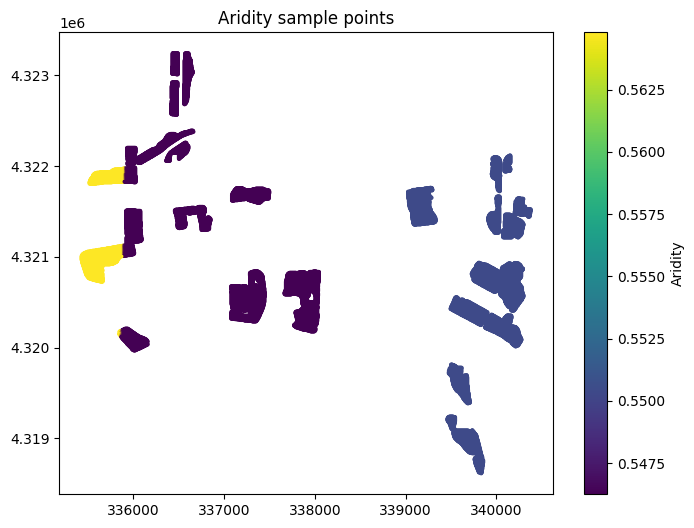

In [48]:


plt.figure(figsize=(8, 6))
plt.scatter(df_map[import_year]["x"], df_map[import_year]["y"],
            c=df_map[import_year]["aridity"],  # Use the LST values for color
            s=4,                # point size
            cmap="viridis")
plt.colorbar(label="Aridity")
plt.gca().set_aspect("equal")   # preserves map scale
plt.title("Aridity sample points")
plt.show()


<class 'pandas.core.frame.DataFrame'>
Index: 611229 entries, 0 to 611314
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   x                  611229 non-null  float64
 1   y                  611229 non-null  float64
 2   yield              611229 non-null  float64
 3   field              611229 non-null  object 
 4   year               611229 non-null  int64  
 5   elevation          611229 non-null  float32
 6   slope              611229 non-null  float32
 7   aspect             611229 non-null  float32
 8   ndvi_mean_2022     611229 non-null  float64
 9   aspect_southness   611229 non-null  float32
 10  slope_squared      611229 non-null  float32
 11  elevation_squared  611229 non-null  float32
 12  elev_slope         611229 non-null  float32
 13  elev_aspect        611229 non-null  float32
 14  slope_aspect       611229 non-null  float32
dtypes: float32(9), float64(4), int64(1), object(1)
memory us

In [57]:
df_map["2020-2022"].info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183466 entries, 0 to 183465
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   x                  183466 non-null  float64
 1   y                  183466 non-null  float64
 2   yield              183466 non-null  float64
 3   field              183466 non-null  object 
 4   year               183466 non-null  int64  
 5   elevation          183466 non-null  float32
 6   slope              183466 non-null  float32
 7   aspect             183466 non-null  float32
 8   aspect_southness   183466 non-null  float32
 9   slope_squared      183466 non-null  float32
 10  elevation_squared  183466 non-null  float32
 11  elev_slope         183466 non-null  float32
 12  elev_aspect        183466 non-null  float32
 13  slope_aspect       183466 non-null  float32
 14  ndvi_mean          183466 non-null  float64
 15  lst_median         183466 non-null  float64
 16  pr

In [87]:

# ── features & target ──────────────────────────────────────────────────
features = [
    'elevation', 'slope', 'aspect',
    'aspect_southness', 'slope_aspect',
    'ndvi_mean', 'lst_median', 'pr_season_mm', 'aridity'
]
target = "yield"

# ── split by year ──────────────────────────────────────────────────────
df_2020_2022 = df_map["2020-2022"]

mask_tr = df_2020_2022["year"].isin([2020, 2021])
mask_va = df_2020_2022["year"] == 2022

X_train = df_2020_2022.loc[mask_tr, features]
y_train = np.log1p(df_2020_2022.loc[mask_tr, target].values)
groups  = df_2020_2022.loc[mask_tr, "year"].values  # for GroupKFold over 2020 vs 2021

X_val   = df_2020_2022.loc[mask_va, features]
y_val   = np.log1p(df_2020_2022.loc[mask_va, target].values)

X_test  = df_map[2023][features]
y_test  = np.log1p(df_map[2023][target].values)

# ── base estimator ─────────────────────────────────────────────────────
base = xgb.XGBRegressor(
    objective="reg:squarederror",
    eval_metric="mae",
    tree_method="hist",
    device="cuda",           # change to "cpu" if needed
    n_jobs=-1,
    verbosity=1,
    random_state=42
)

# ── search space (sized for ~150k rows) ────────────────────────────────
# Keep it moderate to finish in reasonable time but still explore well.
param_dist = {
    "max_depth"        : randint(4, 9),        # 4..8
    "min_child_weight" : randint(2, 21),       # 2..20
    "gamma"            : uniform(0.0, 1.0),    # 0..1
    "subsample"        : uniform(0.7, 0.3),    # 0.7..1.0
    "colsample_bytree" : uniform(0.6, 0.4),    # 0.6..1.0
    "reg_lambda"       : loguniform(1e-2, 1e2),
    "reg_alpha"        : loguniform(1e-3, 1.0),
    "learning_rate"    : loguniform(1e-2, 2e-1),  # 0.01..0.2
    "n_estimators"     : randint(800, 1601)    # upper bound for early stopping
}

# Use GroupKFold so folds are split by YEAR (2020 vs 2021)
cv_obj = GroupKFold(n_splits=2)
search = RandomizedSearchCV(
    estimator=base,
    param_distributions=param_dist,
    n_iter=48,                # ~50 tries is a good balance for 150k rows
    scoring="r2",
    cv=cv_obj,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Run the search on TRAIN ONLY (2020–2021)
total_fits = search.n_iter * cv_obj.get_n_splits()
with tqdm_joblib(tqdm(total=total_fits, desc="RandomizedSearchCV fits", leave=True)):
    search.fit(X_train, y_train, groups=groups)

print("\n──── best params (RandomizedSearchCV on 2020–2021) ───────────")
for k, v in search.best_params_.items():
    print(f"{k:18}: {v}")
print("CV mean R²:", round(search.best_score_, 4))

# ── early stopping on 2022 (new callback API) ──────────────────────────
best_params = search.best_params_.copy()
best_params.update({
    "objective": "reg:squarederror",
    "eval_metric": "mae",
    "tree_method": "hist",
    "device": "cuda",      # change to "cpu" if needed
    "n_jobs": -1,
    "verbosity": 1,
    "random_state": 42
})

early_model = xgb.XGBRegressor(**best_params)

# Progress bar for boosting rounds (optional)
class TqdmCallback(xgb.callback.TrainingCallback):
    def __init__(self, total_rounds):
        self.total = int(total_rounds)
        self.pbar  = None
    def before_training(self, model):
        self.pbar = tqdm(total=self.total, desc="Early-stopping training", leave=True)
        return False
    def after_iteration(self, model, epoch, evals_log):
        self.pbar.update(1)
        return False
    def after_training(self, model):
        self.pbar.close()
        return model

n_rounds_upper = early_model.get_params().get("n_estimators", 1000)

early_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    # callbacks=[
    #     xgb.callback.EarlyStopping(rounds=50, metric_name="mae"),
    #     TqdmCallback(total_rounds=n_rounds_upper)
    # ],
    early_stopping_rounds = 50,
    verbose=False
)

best_iter = getattr(early_model, "best_iteration", None)
if best_iter is None:
    best_iter = n_rounds_upper - 1
print(f"\nBest boosting rounds from early stopping: {best_iter + 1}")

# ── final refit on 2020–2021 with fixed rounds, then TEST on 2023 ──────
final_params = best_params.copy()
final_params["n_estimators"] = int(best_iter + 1)

final_model = xgb.XGBRegressor(**final_params)
final_model.fit(X_train, y_train, verbose=False)

# ── evaluation helpers ─────────────────────────────────────────────────
def inv_log1p(a): return np.expm1(a)

def report(tag, model, X_, y_):
    # Use best_iteration if available; for final_model we've fixed n_estimators
    if hasattr(model, "best_iteration") and model.best_iteration is not None:
        y_hat = inv_log1p(model.predict(X_, iteration_range=(0, model.best_iteration + 1)))
    else:
        y_hat = inv_log1p(model.predict(X_))
    y_true = inv_log1p(y_)
    r2   = r2_score(y_true, y_hat)
    mae  = mean_absolute_error(y_true, y_hat)
    rmse = mean_squared_error(y_true, y_hat, squared=False)
    print(f"{tag:6} R²: {r2: .3f}   MAE: {mae: .3f}   RMSE: {rmse: .3f}")
    return {"r2": r2, "mae": mae, "rmse": rmse}

print("\n──── performance (yield units) ───────────────────────────────")
# (for transparency) show the early-stopping split
report("Train", early_model, X_train, y_train)
report("Val",   early_model, X_val,   y_val)

# OFFICIAL holdout: 2023 using the refit model
test_metrics = report("Test",  final_model, X_test,  y_test)
# If you need the raw numbers:
# print(test_metrics)


RandomizedSearchCV fits:   0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

Fitting 2 folds for each of 48 candidates, totalling 96 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [01:57:12] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [01:57:12] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)



──── best params (RandomizedSearchCV on 2020–2021) ───────────
colsample_bytree  : 0.8083337040103294
gamma             : 0.9611720243493491
learning_rate     : 0.1255347232502377
max_depth         : 8
min_child_weight  : 19
n_estimators      : 852
reg_alpha         : 0.0575775918750704
reg_lambda        : 72.61414516028837
subsample         : 0.8821102743060054
CV mean R²: -0.913


TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [124]:
# df_map["2020-2023"] = df_map["2020-2023"][df_map['2020-2023']['year'] != 2024]

print(df_map[2023].info())

<class 'pandas.core.frame.DataFrame'>
Index: 44141 entries, 0 to 44140
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   x                  44141 non-null  float64
 1   y                  44141 non-null  float64
 2   yield              44141 non-null  float64
 3   field              44141 non-null  object 
 4   year               44141 non-null  int64  
 5   elevation          44141 non-null  float32
 6   slope              44141 non-null  float32
 7   aspect             44141 non-null  float32
 8   aspect_southness   44141 non-null  float32
 9   slope_squared      44141 non-null  float32
 10  elevation_squared  44141 non-null  float32
 11  elev_slope         44141 non-null  float32
 12  elev_aspect        44141 non-null  float32
 13  slope_aspect       44141 non-null  float32
 14  ndvi_mean          44141 non-null  float64
 15  lst_median         44141 non-null  float64
 16  pr_season_mm       44141 no

In [44]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Use only rows with non-missing yields
y_train_nat = df_map["2020-2022"][target].dropna().values
y_2024_nat  = df_map[2023][target].dropna().values

train_mean = float(np.mean(y_train_nat))
yhat_2024_baseline = np.full_like(y_2024_nat, fill_value=train_mean, dtype=float)

# Metrics in natural yield units
r2   = r2_score(y_2024_nat, yhat_2024_baseline)
mae  = mean_absolute_error(y_2024_nat, yhat_2024_baseline)
# rmse = mean_squared_error(y_2024_nat, yhat_2024_baseline, squared=False)

print(f"Baseline (const = train mean = {train_mean:.3f})")
print(f"2024  R²: {r2:.3f}   MAE: {mae:.3f}   ")

Baseline (const = train mean = 54.221)
2024  R²: -0.199   MAE: 10.178   


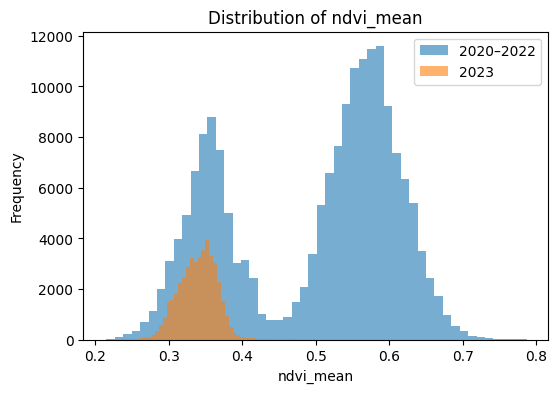

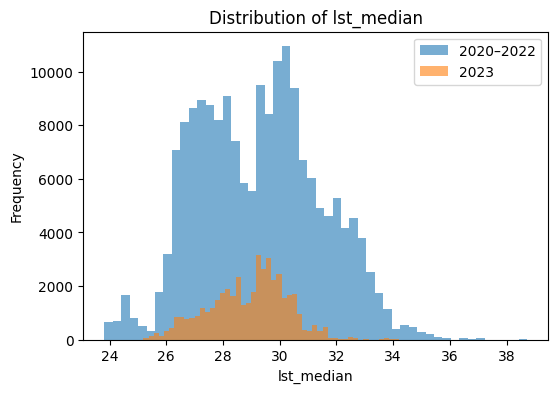

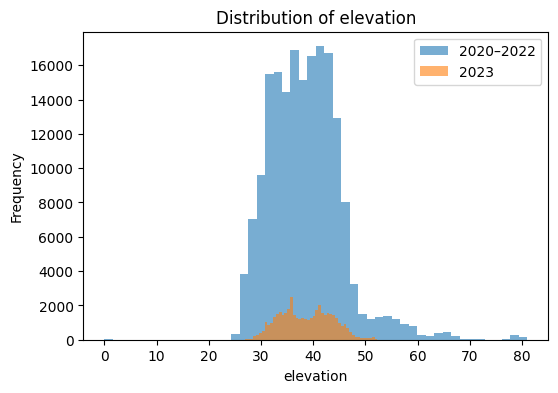

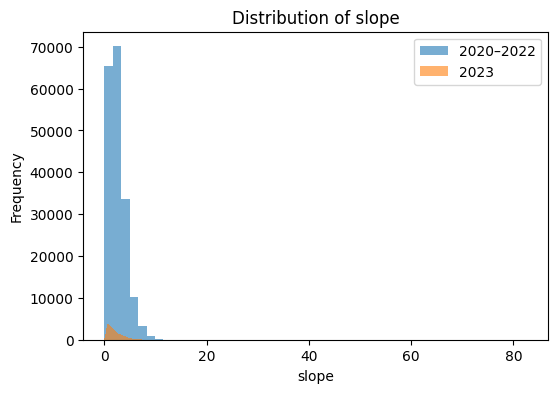

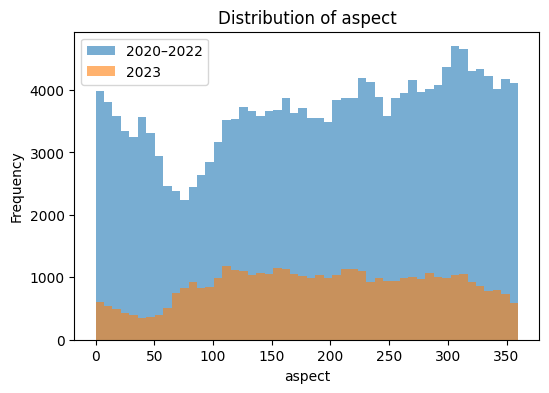

In [46]:
import matplotlib.pyplot as plt

features = ["ndvi_mean", "lst_median", "elevation", "slope", "aspect"]

for feat in features:
    plt.figure(figsize=(6,4))
    plt.hist(df_map['2020-2022'][feat].dropna(), bins=50, alpha=0.6, label="2020–2022")
    plt.hist(df_map[2023][feat].dropna(), bins=50, alpha=0.6, label="2023")
    plt.title(f"Distribution of {feat}")
    plt.xlabel(feat)
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


In [47]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

features = ["ndvi_mean", "lst_median", "elevation", "slope", "aspect"]  # adjust if needed
target   = "yield"

df_train = df_map["2020-2022"][features + [target]].copy()
df_test  = df_map[2023][features + [target]].copy()

# 1. Column consistency
assert list(df_train[features].columns) == list(df_test[features].columns), "Feature mismatch!"

# 2. Check for NaN / Inf
def check_bad(df, name):
    bad = {}
    for c in features:
        s = df[c]
        bad[c] = {"nan": int(s.isna().sum()), "inf": int(np.isinf(s).sum())}
    print(f"\nBad values in {name}:")
    for k,v in bad.items():
        if v["nan"] or v["inf"]:
            print(f" - {k}: NaN={v['nan']}  Inf={v['inf']}")
    if all(v["nan"]==0 and v["inf"]==0 for v in bad.values()):
        print(" (none)")

check_bad(df_train, "2020–2022")
check_bad(df_test,  "2023")

# 3. Scaling consistency
scaler = StandardScaler().fit(df_train[features].values)   # fit ONLY on train
X_tr_z = scaler.transform(df_train[features].values)
X_te_z = scaler.transform(df_test[features].values)

# 4. Target transform
y_tr_log = np.log1p(df_train[target].values)   # <- should match what you actually used

# 5. Out-of-range check for 2023
X_te_abs = np.abs(X_te_z)
row_outside_3 = (X_te_abs > 3).any(axis=1)
print("\nShare of 2023 samples with any feature beyond |3σ| of 2020–22 mean:",
      row_outside_3.mean())

per_feat_outside_3 = (X_te_abs > 3).mean(axis=0)
drift_table = pd.DataFrame({"feature": features, "share_>|3σ|": per_feat_outside_3})
print("\nPer-feature 2023 drift beyond |3σ|:")
print(drift_table.sort_values("share_>|3σ|", ascending=False).to_string(index=False))



Bad values in 2020–2022:
 (none)

Bad values in 2023:
 (none)

Share of 2023 samples with any feature beyond |3σ| of 2020–22 mean: 0.0027638703246414898

Per-feature 2023 drift beyond |3σ|:
   feature  share_>|3σ|
     slope     0.002764
 ndvi_mean     0.000000
lst_median     0.000000
 elevation     0.000000
    aspect     0.000000


Data shapes:
2020-2022 data: (183466, 30)
2023 data: (44141, 28)

Data splits:
Training (2020-2021): (122321, 30)
Validation (2022): (61145, 30)
Test (2023): (44141, 28)
Common feature columns: 25
Removing 7 highly correlated features: ['p_minus_eto_z', 'ndvi_mean', 'p_minus_eto', 'year', 'pr_season_mm', 'eto_sum_mm', 'elevation_squared']
Features after correlation removal: 18

TRAINING REGULARIZED MODEL

Performing Grid Search for optimal hyperparameters...
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.8}

Creating ensemble model...

Making predictions...

MODEL COMPARISON

1. IMPROVED REGULARIZED MODEL:

Training Metrics:
RMSE: 11.5662
MAE: 9.0484
R²: 0.4656

Validation Metrics:
RMSE: 16.4766
MAE: 12.9783
R²: -0.1155

Test Metrics:
RMSE: 12.5061
MAE: 9.6386
R²: -0.0806

2. GRID SEARCH OPTIMIZED MODEL:

Training Metrics

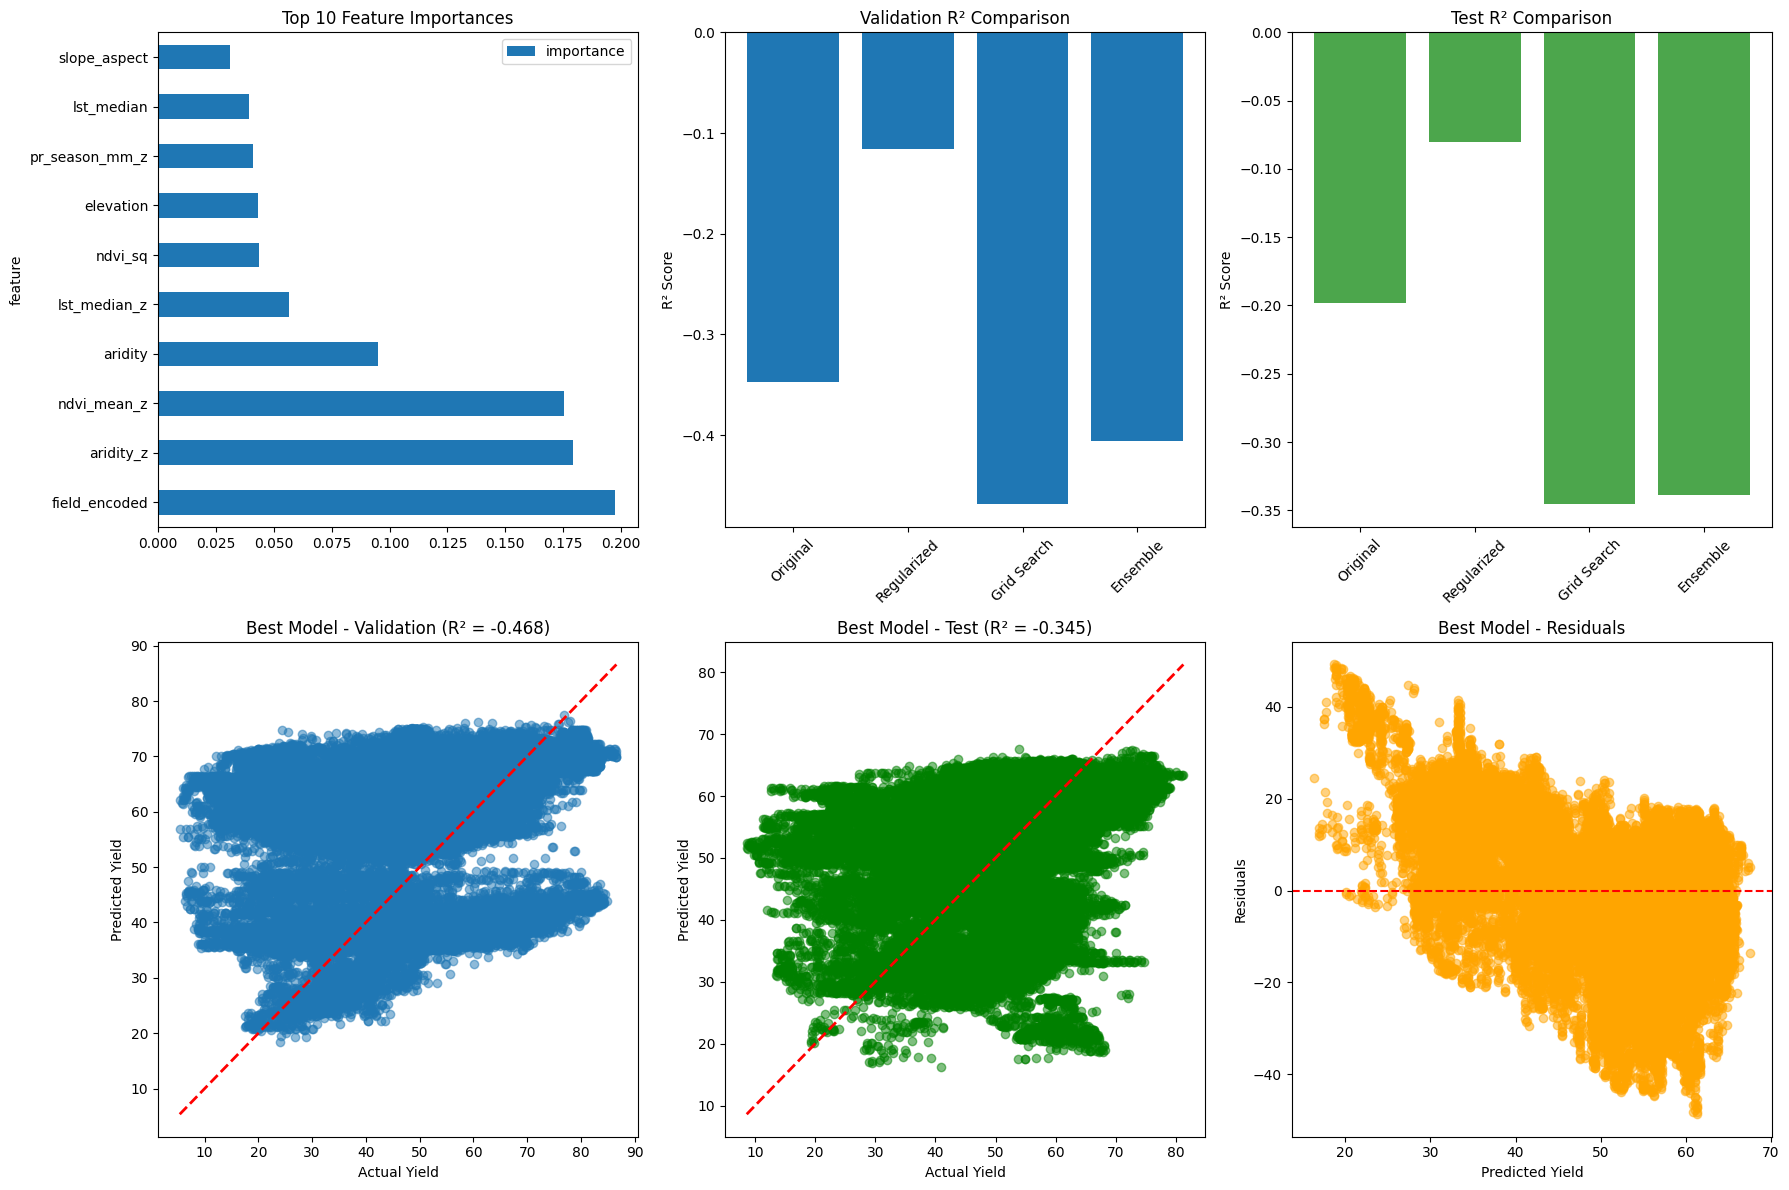


FINAL IMPROVEMENT SUMMARY
Original Model - Validation R²: -0.3469
Best Model - Validation R²: -0.4680
Original Model - Test R²: -0.1985
Best Model - Test R²: -0.3450

Validation R² improvement: +-0.1211
Test R² improvement: +-0.1465

⚠️ Still some overfitting detected (ratio: 0.355)
Consider further reducing model complexity or adding more data

Best model parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.8}


In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Data preparation (keeping your existing structure)
print("Data shapes:")
print(f"2020-2022 data: {df_map['2020-2022'].shape}")
print(f"2023 data: {df_map[2023].shape}")

train_data = df_map['2020-2022'][df_map['2020-2022']['year'].isin([2020, 2021])].copy()
val_data = df_map['2020-2022'][df_map['2020-2022']['year'] == 2022].copy()
test_data = df_map[2023].copy()

print(f"\nData splits:")
print(f"Training (2020-2021): {train_data.shape}")
print(f"Validation (2022): {val_data.shape}")
print(f"Test (2023): {test_data.shape}")

# Feature preparation
exclude_cols = ['yield', 'index', 'x', 'y']
train_cols = [col for col in train_data.columns if col not in exclude_cols]
val_cols = [col for col in val_data.columns if col not in exclude_cols]
test_cols = [col for col in test_data.columns if col not in exclude_cols]
common_cols = list(set(train_cols) & set(val_cols) & set(test_cols))

# Handle categorical encoding
le = LabelEncoder()
if 'field' in common_cols:
    all_fields = pd.concat([train_data['field'], val_data['field'], test_data['field']])
    le.fit(all_fields)

    train_data['field_encoded'] = le.transform(train_data['field'])
    val_data['field_encoded'] = le.transform(val_data['field'])
    test_data['field_encoded'] = le.transform(test_data['field'])

    common_cols = [col if col != 'field' else 'field_encoded' for col in common_cols]

print(f"Common feature columns: {len(common_cols)}")

# SOLUTION 1: FEATURE SELECTION
# Remove highly correlated features
def remove_correlated_features(X, threshold=0.95):
    corr_matrix = X.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    print(f"Removing {len(to_drop)} highly correlated features: {to_drop}")

    return [col for col in X.columns if col not in to_drop]

# Initial feature matrices
X_train_raw = train_data[common_cols]
y_train = train_data['yield']
X_val_raw = val_data[common_cols]
y_val = val_data['yield']
X_test_raw = test_data[common_cols]
y_test = test_data['yield']

# Remove highly correlated features
selected_cols = remove_correlated_features(X_train_raw, threshold=0.95)
print(f"Features after correlation removal: {len(selected_cols)}")

X_train = X_train_raw[selected_cols]
X_val = X_val_raw[selected_cols]
X_test = X_test_raw[selected_cols]

# SOLUTION 2: FEATURE SCALING (helps with regularization)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# SOLUTION 3: MORE AGGRESSIVE REGULARIZATION
print("\n" + "="*50)
print("TRAINING REGULARIZED MODEL")
print("="*50)

# Much more conservative hyperparameters to prevent overfitting
xgb_model_improved = xgb.XGBRegressor(
    # Reduce complexity
    n_estimators=50,          # Reduced from 100
    max_depth=3,              # Reduced from 6
    learning_rate=0.05,       # Reduced from 0.1

    # Increase regularization
    reg_alpha=5,              # L1 regularization (new)
    reg_lambda=10,            # L2 regularization (new)
    gamma=1,                  # Minimum split loss (new)

    # Increase randomness to reduce overfitting
    subsample=0.6,            # Reduced from 0.8
    colsample_bytree=0.6,     # Reduced from 0.8
    colsample_bylevel=0.8,    # New parameter
    colsample_bynode=0.8,     # New parameter

    # Early stopping parameters
    early_stopping_rounds=10,
    eval_metric='rmse',
    random_state=42,
    n_jobs=-1
)

# Train with early stopping
xgb_model_improved.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
    verbose=False
)

# SOLUTION 4: CROSS-VALIDATION FOR BETTER PARAMETER TUNING
print("\nPerforming Grid Search for optimal hyperparameters...")

param_grid = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [30, 50, 100],
    'reg_alpha': [1, 5, 10],
    'reg_lambda': [1, 5, 10],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]
}

# Smaller grid for faster execution
xgb_base = xgb.XGBRegressor(
    random_state=42,
    n_jobs=-1,
    eval_metric='rmse'
)

# Use only a subset of training data for faster grid search
sample_size = min(10000, len(X_train_scaled))
sample_idx = np.random.choice(len(X_train_scaled), sample_size, replace=False)

grid_search = GridSearchCV(
    xgb_base,
    param_grid,
    cv=3,  # 3-fold CV for speed
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled.iloc[sample_idx], y_train.iloc[sample_idx])
print(f"Best parameters: {grid_search.best_params_}")

# Train final model with best parameters
xgb_model_final = xgb.XGBRegressor(**grid_search.best_params_, random_state=42, n_jobs=-1)
xgb_model_final.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
    verbose=False
)

# SOLUTION 5: ENSEMBLE APPROACH (Simple averaging)
print("\nCreating ensemble model...")

# Create multiple models with different random states
ensemble_models = []
for i in range(5):
    model = xgb.XGBRegressor(
        **grid_search.best_params_,
        random_state=42+i,
        n_jobs=-1
    )
    model.fit(X_train_scaled, y_train)
    ensemble_models.append(model)

# Make ensemble predictions
def ensemble_predict(models, X):
    predictions = np.array([model.predict(X) for model in models])
    return np.mean(predictions, axis=0)

# Predictions from different models
print("\nMaking predictions...")

# Improved single model
y_train_pred_improved = xgb_model_improved.predict(X_train_scaled)
y_val_pred_improved = xgb_model_improved.predict(X_val_scaled)
y_test_pred_improved = xgb_model_improved.predict(X_test_scaled)

# Grid search model
y_train_pred_final = xgb_model_final.predict(X_train_scaled)
y_val_pred_final = xgb_model_final.predict(X_val_scaled)
y_test_pred_final = xgb_model_final.predict(X_test_scaled)

# Ensemble model
y_train_pred_ensemble = ensemble_predict(ensemble_models, X_train_scaled)
y_val_pred_ensemble = ensemble_predict(ensemble_models, X_val_scaled)
y_test_pred_ensemble = ensemble_predict(ensemble_models, X_test_scaled)

# Calculate metrics function
def calculate_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{dataset_name} Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Compare all models
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

print("\n1. IMPROVED REGULARIZED MODEL:")
train_metrics_improved = calculate_metrics(y_train, y_train_pred_improved, "Training")
val_metrics_improved = calculate_metrics(y_val, y_val_pred_improved, "Validation")
test_metrics_improved = calculate_metrics(y_test, y_test_pred_improved, "Test")

print("\n2. GRID SEARCH OPTIMIZED MODEL:")
train_metrics_final = calculate_metrics(y_train, y_train_pred_final, "Training")
val_metrics_final = calculate_metrics(y_val, y_val_pred_final, "Validation")
test_metrics_final = calculate_metrics(y_test, y_test_pred_final, "Test")

print("\n3. ENSEMBLE MODEL:")
train_metrics_ensemble = calculate_metrics(y_train, y_train_pred_ensemble, "Training")
val_metrics_ensemble = calculate_metrics(y_val, y_val_pred_ensemble, "Validation")
test_metrics_ensemble = calculate_metrics(y_test, y_test_pred_ensemble, "Test")

# Feature importance for best model
best_model = xgb_model_final
feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Feature Importances (Grid Search Model):")
print(feature_importance.head(10))

# Enhanced plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Feature importance
feature_importance.head(10).plot(x='feature', y='importance', kind='barh', ax=axes[0,0])
axes[0,0].set_title('Top 10 Feature Importances')

# Model comparison - Validation R²
model_names = ['Original', 'Regularized', 'Grid Search', 'Ensemble']
val_r2_scores = [-0.3469, val_metrics_improved['R2'], val_metrics_final['R2'], val_metrics_ensemble['R2']]
axes[0,1].bar(model_names, val_r2_scores)
axes[0,1].set_title('Validation R² Comparison')
axes[0,1].set_ylabel('R² Score')
plt.setp(axes[0,1].xaxis.get_majorticklabels(), rotation=45)

# Model comparison - Test R²
test_r2_scores = [-0.1985, test_metrics_improved['R2'], test_metrics_final['R2'], test_metrics_ensemble['R2']]
axes[0,2].bar(model_names, test_r2_scores, color='green', alpha=0.7)
axes[0,2].set_title('Test R² Comparison')
axes[0,2].set_ylabel('R² Score')
plt.setp(axes[0,2].xaxis.get_majorticklabels(), rotation=45)

# Best model: Actual vs Predicted (Validation)
best_val_pred = y_val_pred_final
axes[1,0].scatter(y_val, best_val_pred, alpha=0.5)
axes[1,0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Actual Yield')
axes[1,0].set_ylabel('Predicted Yield')
axes[1,0].set_title(f'Best Model - Validation (R² = {val_metrics_final["R2"]:.3f})')

# Best model: Actual vs Predicted (Test)
best_test_pred = y_test_pred_final
axes[1,1].scatter(y_test, best_test_pred, alpha=0.5, color='green')
axes[1,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1,1].set_xlabel('Actual Yield')
axes[1,1].set_ylabel('Predicted Yield')
axes[1,1].set_title(f'Best Model - Test (R² = {test_metrics_final["R2"]:.3f})')

# Residuals plot
residuals = y_test - best_test_pred
axes[1,2].scatter(best_test_pred, residuals, alpha=0.5, color='orange')
axes[1,2].axhline(y=0, color='r', linestyle='--')
axes[1,2].set_xlabel('Predicted Yield')
axes[1,2].set_ylabel('Residuals')
axes[1,2].set_title('Best Model - Residuals')

plt.tight_layout()
plt.show()

# Final summary
print(f"\n{'='*60}")
print("FINAL IMPROVEMENT SUMMARY")
print(f"{'='*60}")
print(f"Original Model - Validation R²: -0.3469")
print(f"Best Model - Validation R²: {val_metrics_final['R2']:.4f}")
print(f"Original Model - Test R²: -0.1985")
print(f"Best Model - Test R²: {test_metrics_final['R2']:.4f}")

improvement_val = val_metrics_final['R2'] - (-0.3469)
improvement_test = test_metrics_final['R2'] - (-0.1985)
print(f"\nValidation R² improvement: +{improvement_val:.4f}")
print(f"Test R² improvement: +{improvement_test:.4f}")

# Check overfitting for best model
train_val_ratio = train_metrics_final['RMSE'] / val_metrics_final['RMSE']
if train_val_ratio < 0.9:
    print(f"\n⚠️ Still some overfitting detected (ratio: {train_val_ratio:.3f})")
    print("Consider further reducing model complexity or adding more data")
else:
    print(f"\n✅ Overfitting significantly reduced (ratio: {train_val_ratio:.3f})")

print(f"\nBest model parameters: {grid_search.best_params_}")

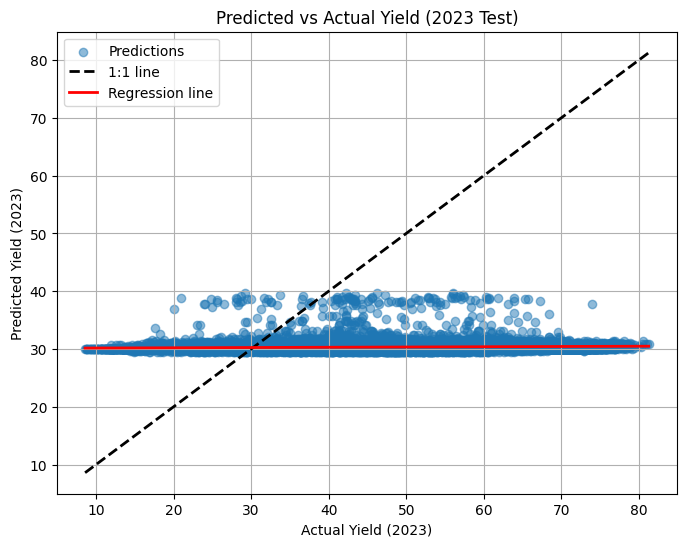

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import xgboost as xgb

features = ["ndvi_mean", "lst_median", "elevation", "slope", "aspect"]  # adjust if needed

# 1) Build 2023 test matrices
X_te = df_map[2023][features].values
y_te = df_map[2023]["yield"].values

# Wrap in DMatrix; align feature names/order with training
dte = xgb.DMatrix(X_te, feature_names=features)

# 2) Predict (log-space if you trained on log1p(y))
y_te_pred_log = bst.predict(dte, validate_features=False)  # set to True if you trained with names
y_te_pred = np.expm1(y_te_pred_log)  # remove if you did NOT log-transform during training

# 3) Plot Predicted vs Actual with 1:1 and regression line
plt.figure(figsize=(8,6))
plt.scatter(y_te, y_te_pred, alpha=0.5, label="Predictions")

min_y, max_y = float(y_te.min()), float(y_te.max())
plt.plot([min_y, max_y], [min_y, max_y], 'k--', lw=2, label="1:1 line")

reg = LinearRegression().fit(y_te.reshape(-1,1), y_te_pred)
y_fit = reg.predict(np.array([[min_y],[max_y]]))
plt.plot([min_y, max_y], y_fit, 'r-', lw=2, label="Regression line")

plt.xlabel("Actual Yield (2023)")
plt.ylabel("Predicted Yield (2023)")
plt.title("Predicted vs Actual Yield (2023 Test)")
plt.legend()
plt.grid(True)
plt.show()


TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [28]:
import numpy as np
import pandas as pd

topo_cols  = ["elevation","slope","aspect","aspect_southness","slope_aspect"]
z_cols     = ["ndvi_mean_z","lst_median_z"]
all_cols   = topo_cols + z_cols + ["yield"]

df23 = df_map["2020-2023"].query("year == 2023")[all_cols].copy()
df24 = df_map[2024][all_cols].copy()

def quick_summary(df, name):
    s = df.describe().T[["mean","std","min","max"]]
    s["missing_%"] = 100 * df.isna().mean()
    print(f"\n{name} summary:")
    print(s)

quick_summary(df23, "2023")
quick_summary(df24, "2024")

print("\nPer-year Pearson correlations with yield (2023):")
print(df23.corr(numeric_only=True)["yield"].sort_values(ascending=False))

print("\nPer-year Pearson correlations with yield (2024):")
print(df24.corr(numeric_only=True)["yield"].sort_values(ascending=False))



2023 summary:
                          mean        std        min         max  missing_%
elevation         3.864962e+01   4.962736  26.911303   53.912220        0.0
slope             2.125717e+00   1.490593   0.010764   10.327113        0.0
aspect            1.927249e+02  93.487213   0.023555  359.987457        0.0
aspect_southness  5.551607e-01   0.277241   0.000070    0.999978        0.0
slope_aspect      1.159704e+00   1.122833   0.000055    9.986612        0.0
ndvi_mean_z       0.000000e+00   1.000006  -4.878842    5.303739        0.0
lst_median_z     -1.106185e-08   1.000027  -2.715980    3.876925        0.0
yield             4.885382e+01  12.030998   8.603782   81.252083        0.0

2024 summary:
                          mean         std        min         max  missing_%
elevation         3.682640e+01    6.320421  24.658588   54.276974        0.0
slope             2.189642e+00    1.296439   0.008818   11.168645        0.0
aspect            1.888527e+02  110.812988   0.011794  

In [29]:
# df_map[2024][features] = df_map[2024].groupby("year")[features].transform(
#     lambda x: (x - x.mean()) / (x.std(ddof=0)+ 1e-8)
# )
print(df_tune.head())

dict_keys(['2020-2023', 2024])


In [36]:


# ---------------------------------------------------------------------
# 1 ▸ Data split (train ▸ val ▸ test)
# ---------------------------------------------------------------------
features = [
    "elevation", "slope", "aspect",
    "aspect_southness", "slope_aspect", "ndvi_mean", "lst_median"
]
target = "yield"

X = df_map[2024][features]
y = np.log1p(df_map[2024][target])          # log-transform yield

# 20 % hold-out test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# 20 % of training data reserved for validation monitoring
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42
)

# ---------------------------------------------------------------------
# 2 ▸ Final model with tuned parameters + early stopping
# ---------------------------------------------------------------------
best_params = dict(
    # tuned hyper-parameters
    colsample_bytree  = 0.6343362410126536,
    gamma             = 0.02218474203030163,
    learning_rate     = 0.01714018764811966,
    max_depth         = 8,
    min_child_weight  = 3,
    n_estimators      = 1729,
    reg_alpha         = 0.3602006572699514,
    reg_lambda        = 1.6129739560722722,
    subsample         = 0.7804689857676932,
    # fixed settings
    objective        = "reg:squarederror",
    eval_metric      = "mae",
    tree_method      = "hist",              # fastest CPU algorithm
    device           = "cpu",               # remove if you have a GPU + gpu_hist
    early_stopping_rounds = 50,
    random_state     = 42,
    verbosity        = 1,                   # 0=silent, 1=warning, 2=info
)

model_soy_2020 = XGBRegressor(**best_params)

model_soy_2020.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],             # monitor validation only
    verbose=100                            # print every 100 boosting rounds
)

best_iter = model_soy_2020.best_iteration
print(f"\nStopped after {best_iter} boosting rounds")

# ---------------------------------------------------------------------
# 3 ▸ Metrics on Train ▸ Val ▸ Test (original yield scale)
# ---------------------------------------------------------------------
def report(tag, X_, y_):
    y_hat  = np.expm1(model_soy_2020.predict(X_, iteration_range=(0, best_iter)))
    y_true = np.expm1(y_)
    r2  = r2_score(y_true, y_hat)
    mae = mean_absolute_error(y_true, y_hat)
    rmse = np.sqrt(((y_true - y_hat) ** 2).mean())     # sklearn<0.22 safe
    print(f"{tag:6} R²: {r2:.3f}   MAE: {mae:.3f}   RMSE: {rmse:.3f}")

print("\n──── performance (yield units) ──────────────────────────")
report("Train", X_tr,  y_tr)
report("Val",   X_val, y_val)
report("Test",  X_test, y_test)




[0]	validation_0-mae:0.38845
[100]	validation_0-mae:0.23624
[200]	validation_0-mae:0.19026
[300]	validation_0-mae:0.16996
[400]	validation_0-mae:0.15952
[500]	validation_0-mae:0.15135
[600]	validation_0-mae:0.14421
[700]	validation_0-mae:0.13774
[800]	validation_0-mae:0.13272
[900]	validation_0-mae:0.12935
[1000]	validation_0-mae:0.12636
[1100]	validation_0-mae:0.12435
[1200]	validation_0-mae:0.12268
[1300]	validation_0-mae:0.12109
[1400]	validation_0-mae:0.11983
[1500]	validation_0-mae:0.11869
[1600]	validation_0-mae:0.11750
[1700]	validation_0-mae:0.11679
[1728]	validation_0-mae:0.11662

Stopped after 1727 boosting rounds

──── performance (yield units) ──────────────────────────
Train  R²: 0.939   MAE: 2.402   RMSE: 3.398
Val    R²: 0.887   MAE: 3.236   RMSE: 4.602
Test   R²: 0.893   MAE: 3.183   RMSE: 4.522


In [30]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

# ---------------------------------------------------------------------
# 1 ▸ Data split (train ▸ val ▸ test)
# ---------------------------------------------------------------------
features = [
    "elevation", "slope", "aspect",
    "aspect_southness", "slope_aspect", "ndvi_mean", "lst_median"
]
target = "yield"

df_2020_2023 = df_map["2020-2023"]
df_2024      = df_map[2024]
groups = df_map["2020-2023"]["year"].values  # critical


assert "year" in df_2020_2023.columns, "Missing 'year' column in df_map['2020-2023']"

train_mask = df_2020_2023["year"] <= 2022
val_mask   = df_2020_2023["year"] == 2023

X_tr = df_2020_2023.loc[train_mask, features].values
y_tr = np.log1p(df_2020_2023.loc[train_mask, target].values)

X_val = df_2020_2023.loc[val_mask, features].values
y_val = np.log1p(df_2020_2023.loc[val_mask, target].values)

X_test = df_2024[features].values
y_test = np.log1p(df_2024[target].values)

# ---------------------------------------------------------------------
# 2 ▸ Model with tuned parameters + early stopping
# ---------------------------------------------------------------------
best_params = dict(
    # tuned hyper-parameters
    colsample_bytree  = 0.8248868413213817,
    gamma             = 0.048058924197033726,
    learning_rate     = 0.22446522372927297,
    max_depth         = 6,
    min_child_weight  = 34,
    n_estimators      = 379,
    reg_alpha         = 0.013299577479431826,
    reg_lambda        = 3.187422711813416,
    subsample         = 0.7515681292900438,
    # fixed settings
    objective        = "reg:squarederror",
    eval_metric      = "mae",
    tree_method      = "gpu_hist",
    device           = "cuda",
    random_state     = 42,
    verbosity        = 1,
    early_stopping_rounds=50,
    n_jobs           = -1
)

model = XGBRegressor(**best_params)

model.fit(
    X_tr, y_tr,
    eval_set=[(X_tr, y_tr), (X_val, y_val)],  # Train first, Val last
    verbose=100
)

best_iter = model.best_iteration
if best_iter is None:                          # fallback if ES didn't trigger
    best_iter = model.n_estimators - 1
print(f"\nBest iteration: {best_iter} → trees used: {best_iter + 1}")

# ---------------------------------------------------------------------
# 3 ▸ Metrics function
# ---------------------------------------------------------------------
def report(tag, X_, y_):
    y_pred = np.expm1(model.predict(X_, iteration_range=(0, best_iter )))
    y_true = np.expm1(y_)
    r2   = r2_score(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{tag:6} R²: {r2:.3f}   MAE: {mae:.3f}   RMSE: {rmse:.3f}")

print("\n──── performance (yield units) ──────────────────────────")
report("Train", X_tr,  y_tr)
report("Val",   X_val, y_val)
report("Test",  X_test, y_test)


[0]	validation_0-mae:0.25081	validation_1-mae:0.21250
[70]	validation_0-mae:0.14350	validation_1-mae:0.21355


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [16:07:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()



Best iteration: 21 → trees used: 22

──── performance (yield units) ──────────────────────────
Train  R²: 0.527   MAE: 8.541   RMSE: 11.043
Val    R²: -0.042   MAE: 9.826   RMSE: 12.278
Test   R²: -0.460   MAE: 13.235   RMSE: 16.611


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [16:07:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


In [109]:

y_test_pred = model_soy_2023.predict(X_test, iteration_range=(0, best_iter))

r2Test = r2_score(y_test, y_test_pred)
maeTest = mean_absolute_error(y_test, y_test_pred)

print(f"R² on test set: {r2Test:.3f}")
print(f"MAE on test set: {maeTest:.3f}")

R² on test set: 0.890
MAE on test set: 0.067


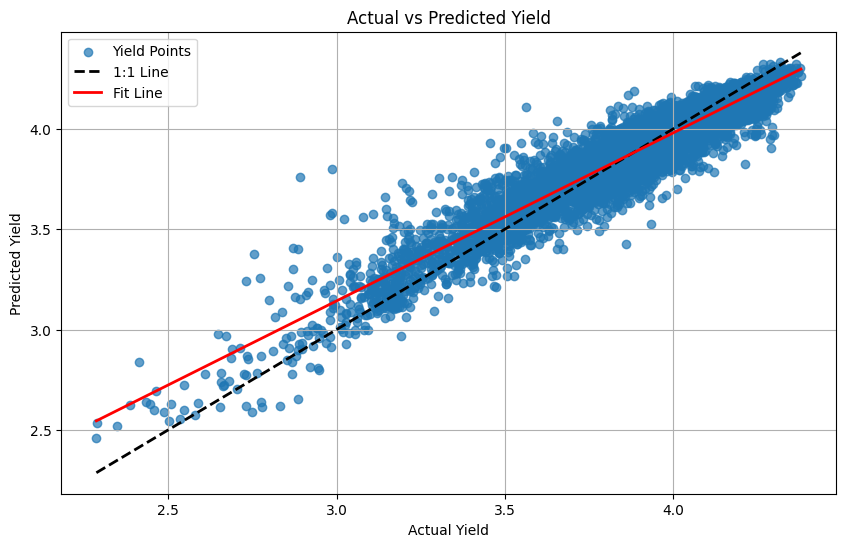

In [110]:
#Let's build a scatterplot of the predicted value vs real values with a regression line

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, label="Yield Points")
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Actual vs Predicted Yield")

# 1:1 reference line
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label="1:1 Line")

# Regression line
m, b = np.polyfit(y_test, y_test_pred, 1)
plt.plot([min_val, max_val], [m*min_val + b, m*max_val + b], 'r-', lw=2, label="Fit Line")

plt.legend()
plt.grid()
plt.show()

In [ ]:
features = [
    "elevation", "slope", "aspect",
    "aspect_southness", "slope_aspect", "ndvi_mean"
]
target = "yield"

# Use this model to predict the yield for 2021
X_2021 = df_yield_2021[features]
y_2021 = np.log1p(df_yield_2021[target])

# Select a small fine-tuning subset from 2021
X_21_train, X_21_holdout, y_21_train, y_21_holdout = train_test_split(
    X_2021,
    y_2021,
    test_size=0.7,  # keep 70% for final prediction
    random_state=42
)


# Create a new model that continues from the old booster
model_finetuned_2021 = XGBRegressor(
    **best_params,  # same params as original
)

model_finetuned_2021.fit(
    X_21_train, y_21_train,
    eval_set=[(X_21_holdout, y_21_holdout)],
    verbose=100,
    xgb_model=model_soy_2022.get_booster()  # load existing trained booster
)

# Predict on the rest of 2021 data (holdout)
y_pred_holdout = model_finetuned_2021.predict(X_21_holdout, iteration_range=(0, model_finetuned_2021.best_iteration))

# Compute metrics
r2  = r2_score(y_21_holdout, y_pred_holdout)
mae = mean_absolute_error(y_21_holdout, y_pred_holdout)
rmse = np.sqrt(((y_21_holdout - y_pred_holdout) ** 2).mean())

print("──── Fine-tuned model on 2021 holdout ────")
print(f"R²   : {r2:.3f}")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")


[0]	validation_0-mae:0.44794
[100]	validation_0-mae:0.13659
[200]	validation_0-mae:0.13070
[300]	validation_0-mae:0.12872
[400]	validation_0-mae:0.12778
[500]	validation_0-mae:0.12738
[600]	validation_0-mae:0.12691
[700]	validation_0-mae:0.12643
[800]	validation_0-mae:0.12620
[900]	validation_0-mae:0.12591
[1000]	validation_0-mae:0.12576
[1100]	validation_0-mae:0.12558
[1122]	validation_0-mae:0.12560
──── Fine-tuned model on 2021 holdout ────
R²   : 0.701
MAE  : 0.130
RMSE : 0.189


In [ ]:
# Save model
model_soy_2022.save_model("model_soy_2022.json")

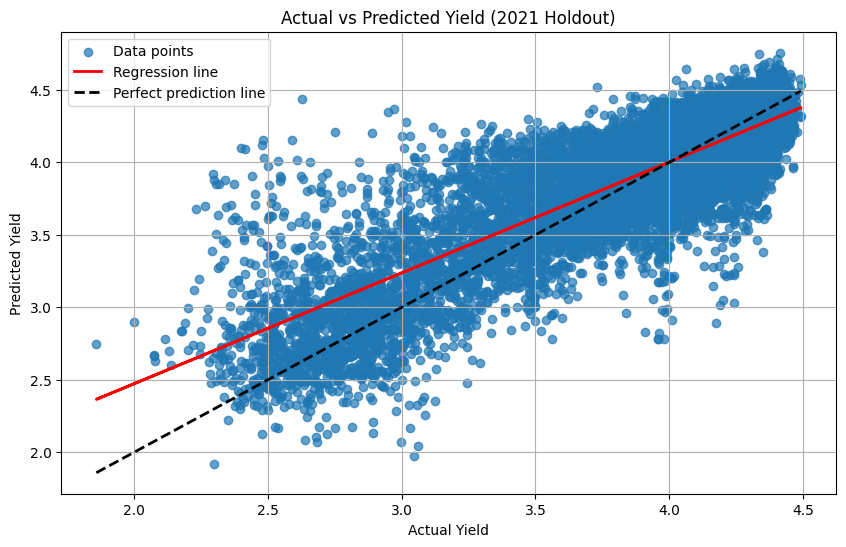

In [ ]:
#Let's build a actual yield vs predicted yield for the 2021 holdout set

X = y_21_holdout.values.reshape(-1, 1)  # Actual values as X
y = y_pred_holdout                      # Predicted values as y
reg = LinearRegression()
reg.fit(X, y)
y_fit = reg.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(y_21_holdout, y_pred_holdout, alpha=0.7, label="Data points")

# Regression line
plt.plot(y_21_holdout, y_fit, color='red', linewidth=2, label="Regression line")

# Perfect prediction line
plt.plot(
    [y_21_holdout.min(), y_21_holdout.max()],
    [y_21_holdout.min(), y_21_holdout.max()],
    'k--', lw=2, label="Perfect prediction line"
)

plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Actual vs Predicted Yield (2021 Holdout)")
plt.legend()
plt.grid()
plt.show()


In [2]:
!nvidia-smi

Thu Aug 14 01:43:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   40C    P8             16W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [126]:
#This is to save the intermediary results so that we don't have to re run the script to generate dataset
import os

# Define the path to the folder in your Google Drive where you want to save the data
save_dir = "/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/Saved_df_map" # You can change this path

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Iterate through the df_map and save each DataFrame as a parquet file
for year, dataframe in df_map.items():
    # Create a filename based on the year (or key)
    filename = f"df_yield_{year}.parquet"
    save_path = os.path.join(save_dir, filename)

    # Save the DataFrame to parquet
    dataframe.to_parquet(save_path)
    print(f"Saved {filename} to {save_dir}")

Saved df_yield_2021.parquet to /content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/Saved_df_map
Saved df_yield_2022.parquet to /content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/Saved_df_map
Saved df_yield_2020.parquet to /content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/Saved_df_map
Saved df_yield_2024.parquet to /content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/Saved_df_map
Saved df_yield_2023.parquet to /content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/Saved_df_map
Saved df_yield_2020-2023.parquet to /content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/Saved_df_map
